In [11]:
import os
import cv2
from ultralytics import YOLO
from IPython.display import Image,display
import torch
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

# Define the directories for images and annotations
image_dir = 'train/images'  # Update this path if needed
annotation_dir = 'train/labels'  # Ensure your annotation files are stored here

# Function to display images with bounding boxes
def display_bounding_boxes(image_dir, annotation_dir):
    if not os.path.isdir(image_dir):
        print(f"Image directory '{image_dir}' not found.")
        return
    if not os.path.isdir(annotation_dir):
        print(f"Annotation directory '{annotation_dir}' not found.")
        return

    print(f"Processing images in directory: {image_dir}")
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.jpg') or img_name.endswith('.png'):
            # Load image
            img_path = os.path.join(image_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not load image: {img_path}")
                continue

            h, w, _ = img.shape
            print(f"Loaded image: {img_path} with dimensions (width={w}, height={h})")

            # Load corresponding bounding box file
            label_path = os.path.join(annotation_dir, os.path.splitext(img_name)[0] + '.txt')
            if os.path.exists(label_path):
                with open(label_path, 'r') as file:
                    for line in file:
                        label = line.strip().split()
                        if len(label) == 5:
                            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label)
                            # Convert YOLO format to bounding box coordinates
                            x1 = int((x_center - bbox_width / 2) * w)
                            y1 = int((y_center - bbox_height / 2) * h)
                            x2 = int((x_center + bbox_width / 2) * w)
                            y2 = int((y_center + bbox_height / 2) * h)

                            # Draw the bounding box
                            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                            # Display class label
                            cv2.putText(img, 'windshield', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            else:
                print(f"Bounding box file not found for image: {img_name}")
                continue

            # Display the image with bounding boxes
            cv2.imshow('Bounding Box', img)
            cv2.waitKey(0)

    cv2.destroyAllWindows()

# Run the function on the specified directories
display_bounding_boxes(image_dir, annotation_dir)


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')


Using cuda device


In [ ]:
model = YOLO('yolo11m.pt')  
model.train(data='data.yaml', epochs=120, imgsz=640, device=device, batch=8, plots=True)

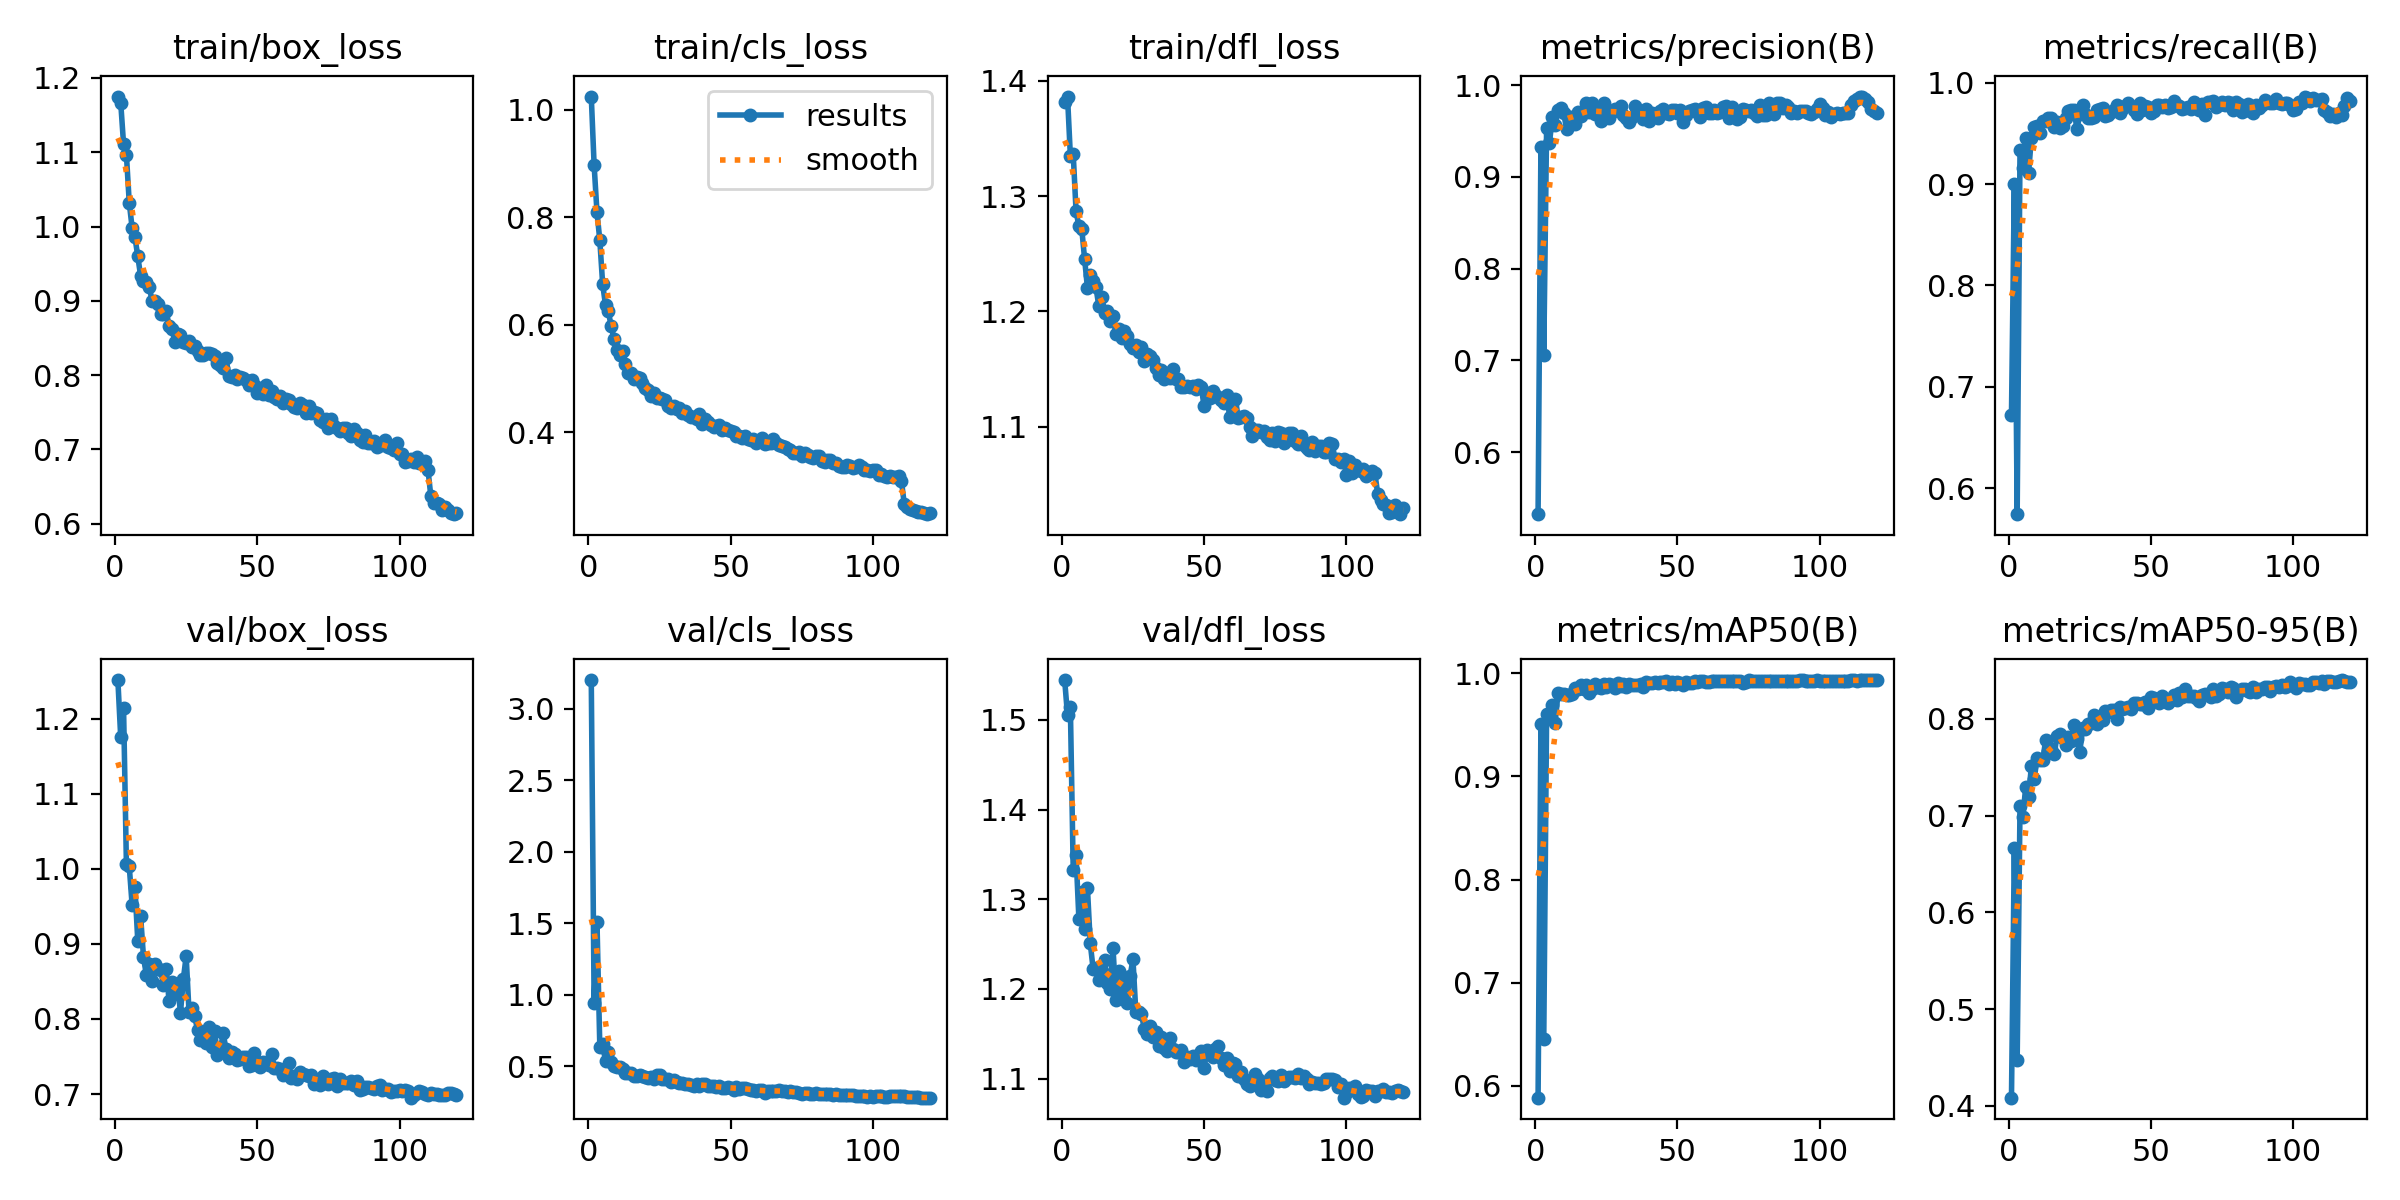

In [3]:
display(Image(filename="runs/detect/train/results.png"))

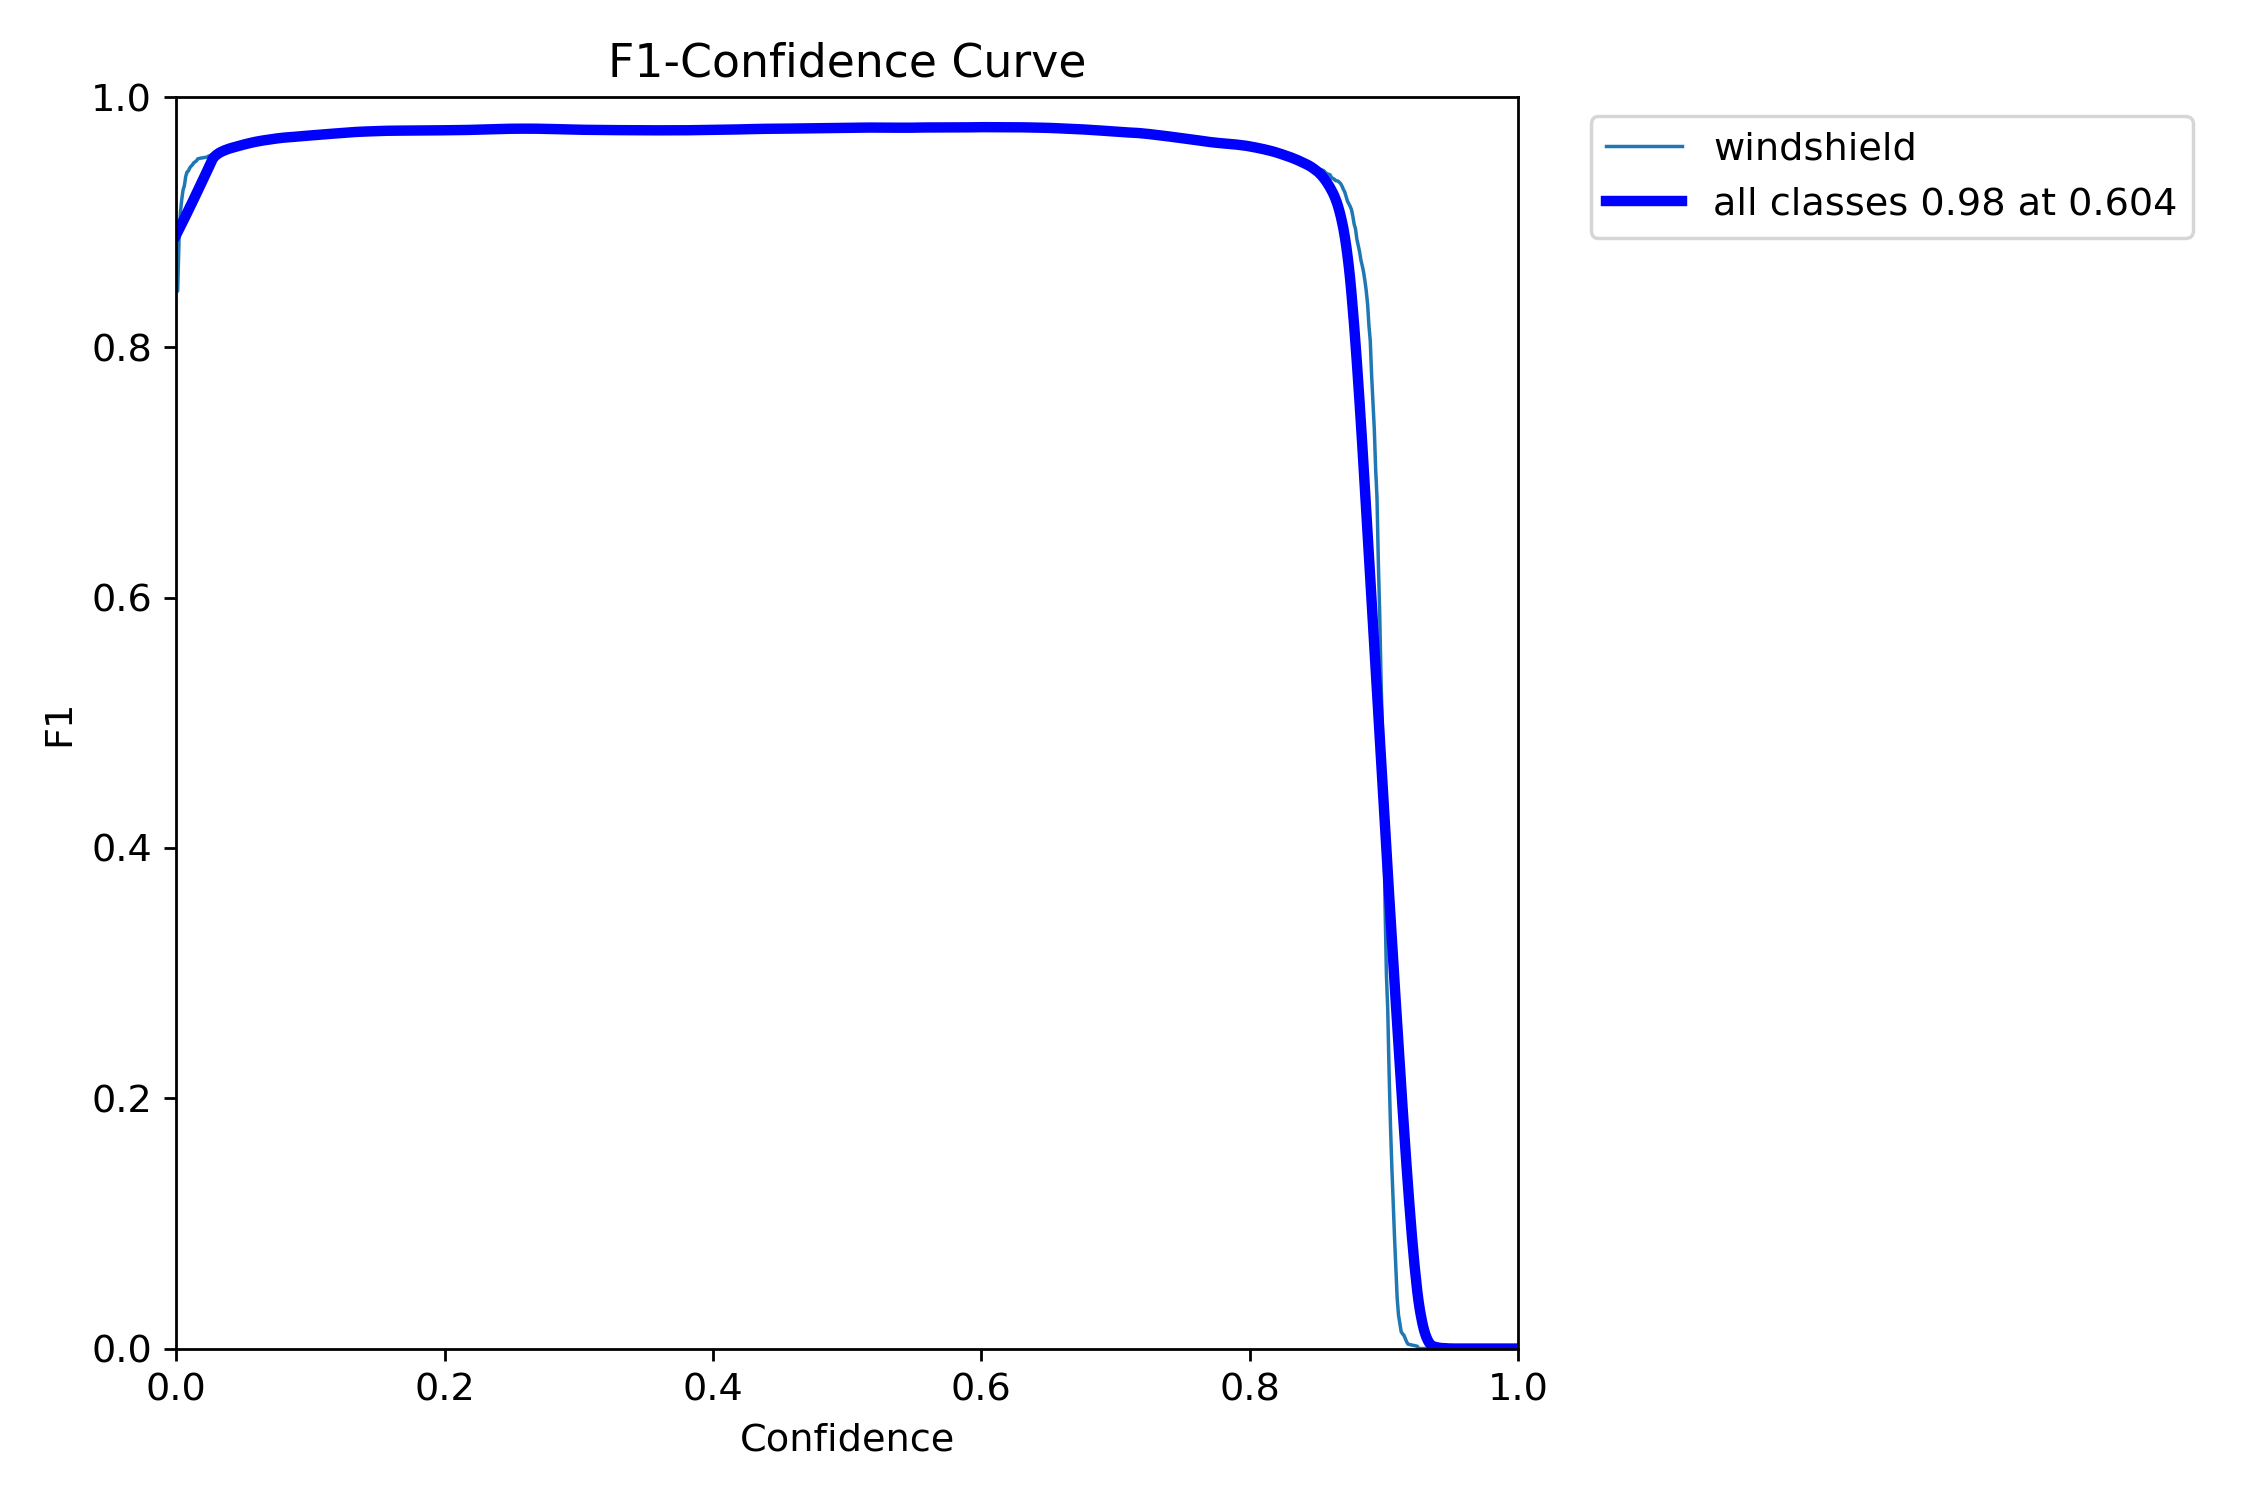

In [6]:
display(Image(filename="runs/detect/train/F1_curve.png"))

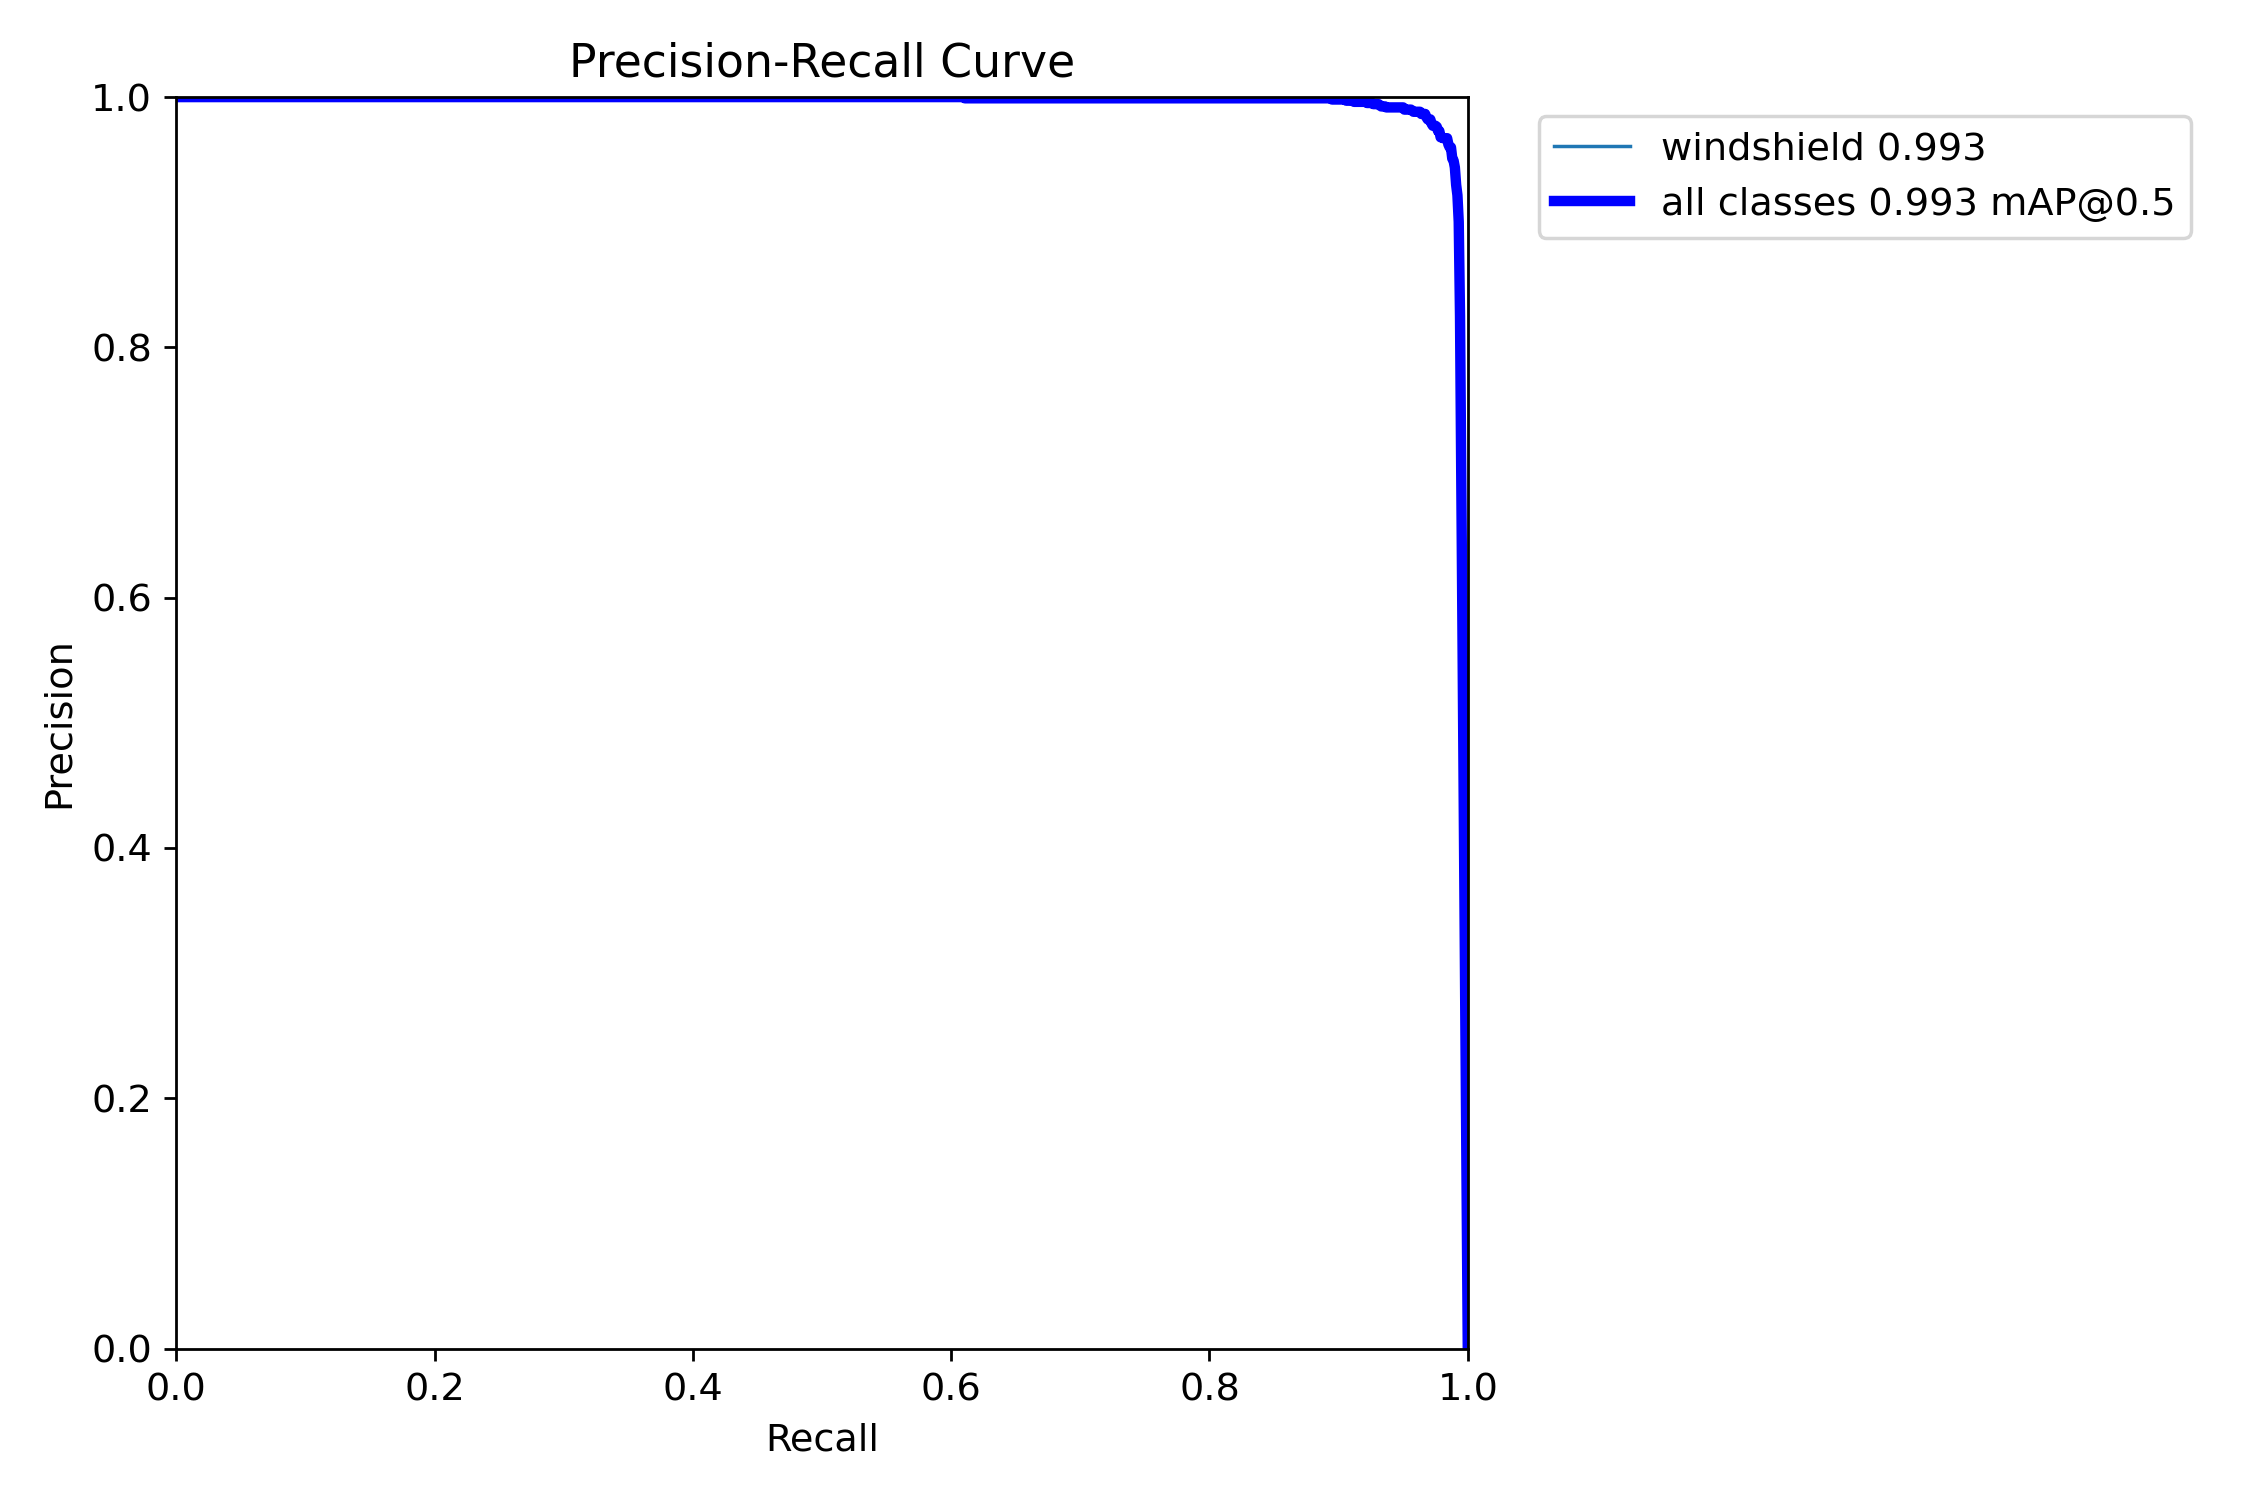

In [5]:
display(Image(filename="runs/detect/train/PR_curve.png"))

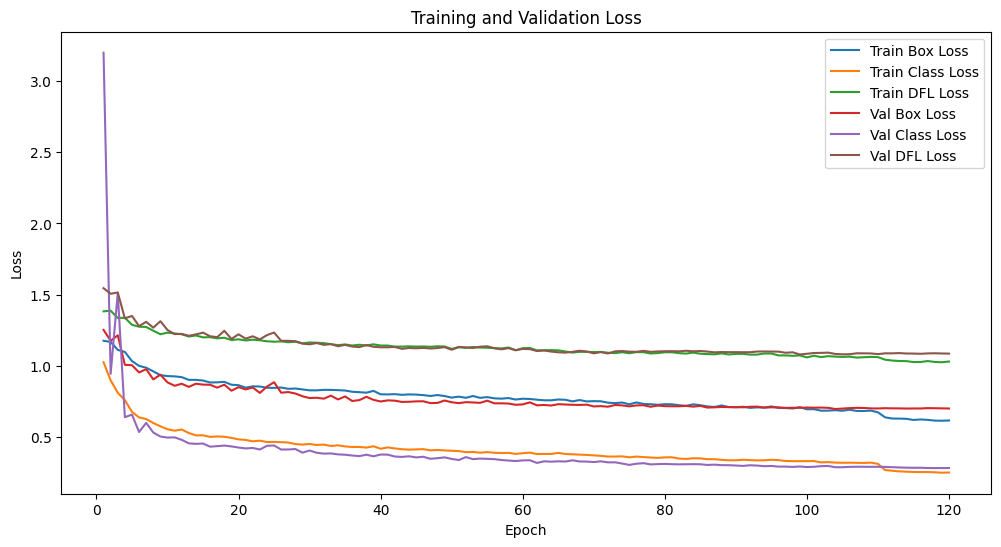

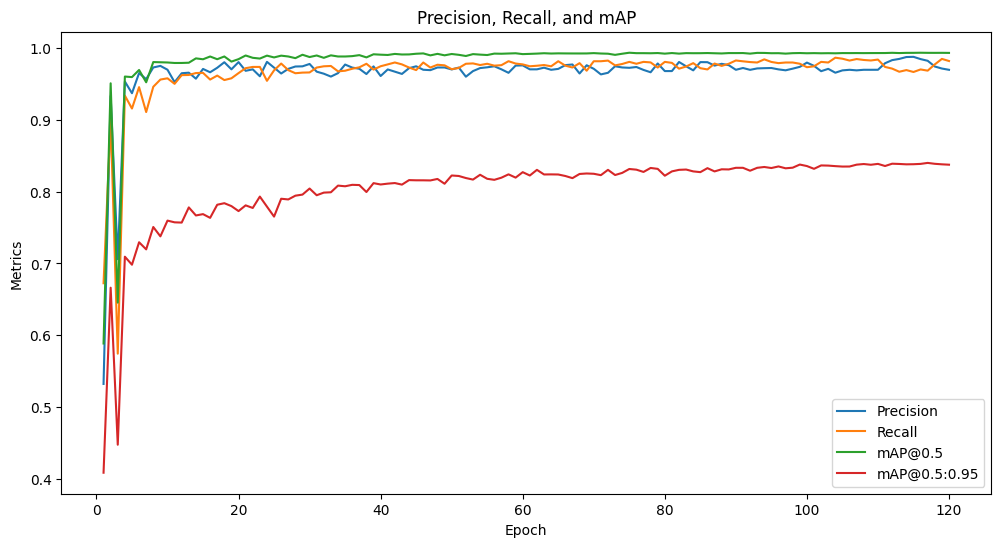

In [12]:
# Load training results
results_path = 'runs/detect/train/results.csv'  # adjust the path as needed
df = pd.read_csv(results_path)

# Plot loss metrics
plt.figure(figsize=(12, 6))
if 'train/box_loss' in df.columns:
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
if 'train/cls_loss' in df.columns:
    plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
if 'train/dfl_loss' in df.columns:
    plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
if 'val/box_loss' in df.columns:
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
if 'val/cls_loss' in df.columns:
    plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
if 'val/dfl_loss' in df.columns:
    plt.plot(df['epoch'], df['val/dfl_loss'], label='Val DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot precision, recall, and mAP metrics
plt.figure(figsize=(12, 6))
if 'metrics/precision(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
if 'metrics/recall(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
if 'metrics/mAP50(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
if 'metrics/mAP50-95(B)' in df.columns:
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Precision, Recall, and mAP')
plt.legend()
plt.show()


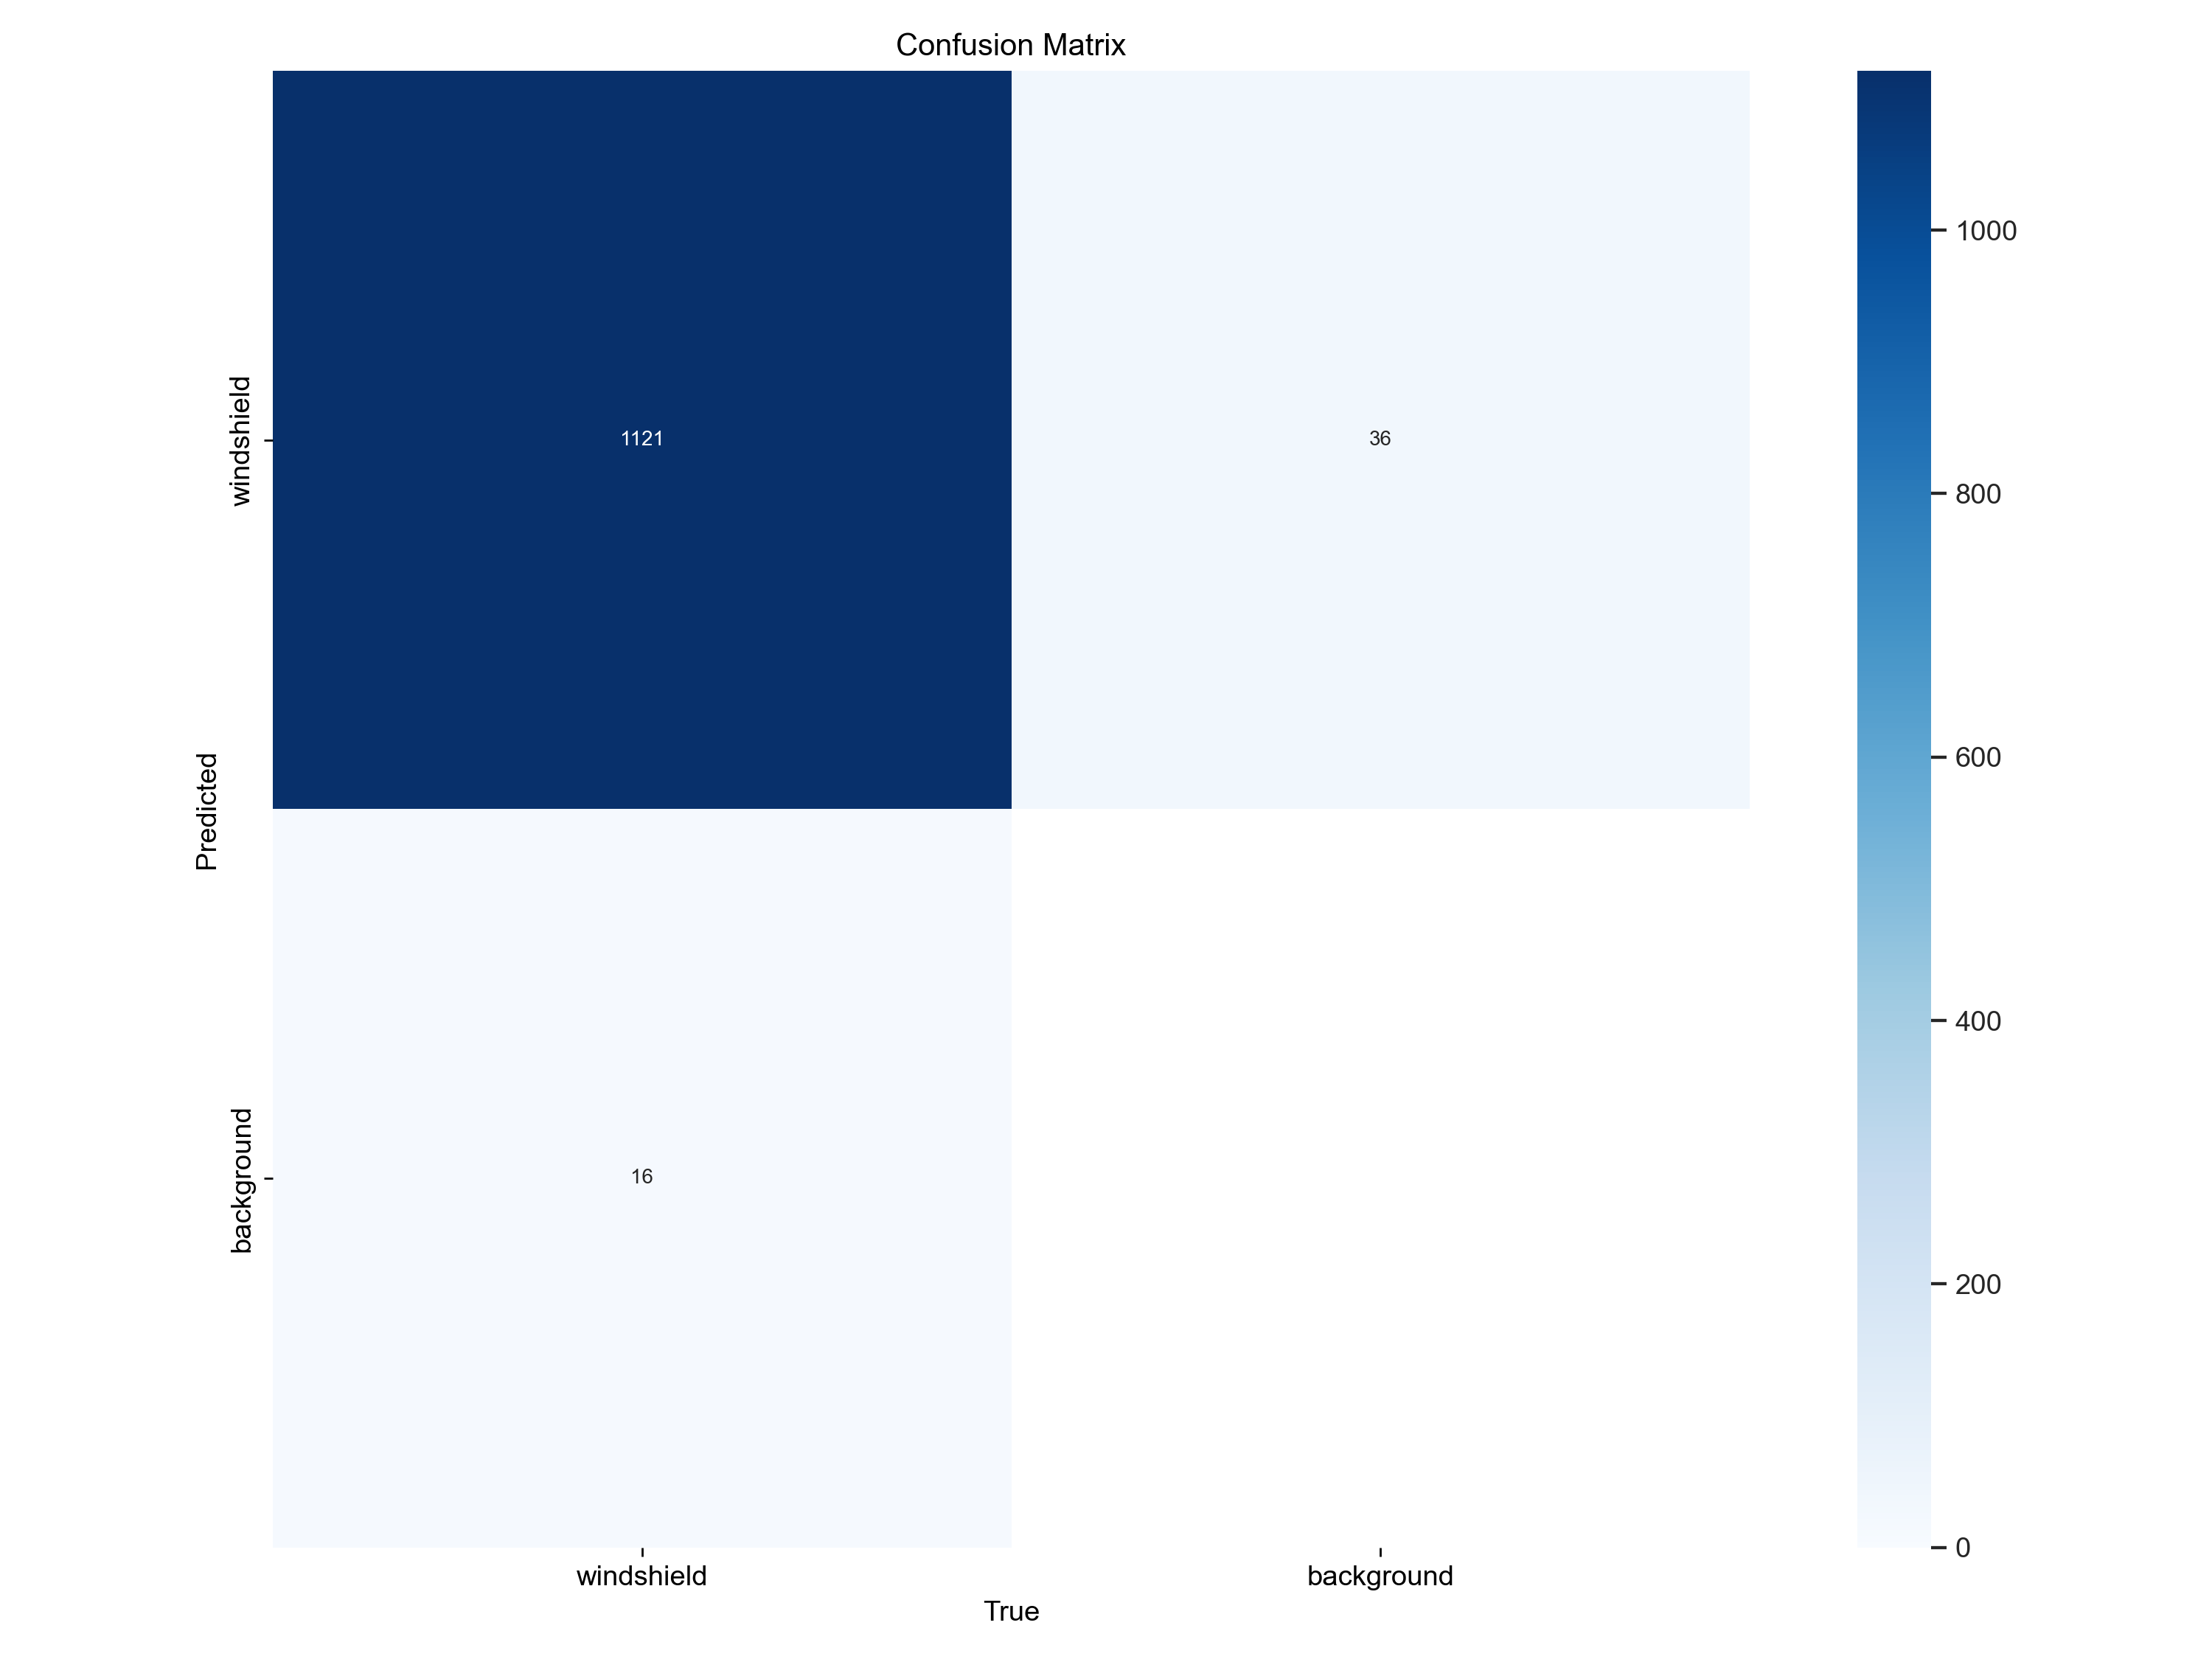

In [14]:
display(Image(filename="runs/detect/train/confusion_matrix.png"))

In [4]:
# Load the model
model = YOLO("runs/detect/train/weights/best.pt")

In [6]:
results_val= model.val(data="data.yaml", task="detect",device=device, split="val")

Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)


val: Scanning C:\Users\Tamer\OneDrive\Documents\GitHub\Seat_Belt_Detection\valid\labels.cache... 1013 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1013/1013 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.11it/s]


                   all       1013       1137      0.982      0.968      0.993       0.84
Speed: 0.2ms preprocess, 9.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to C:\Users\Tamer\runs\detect\val


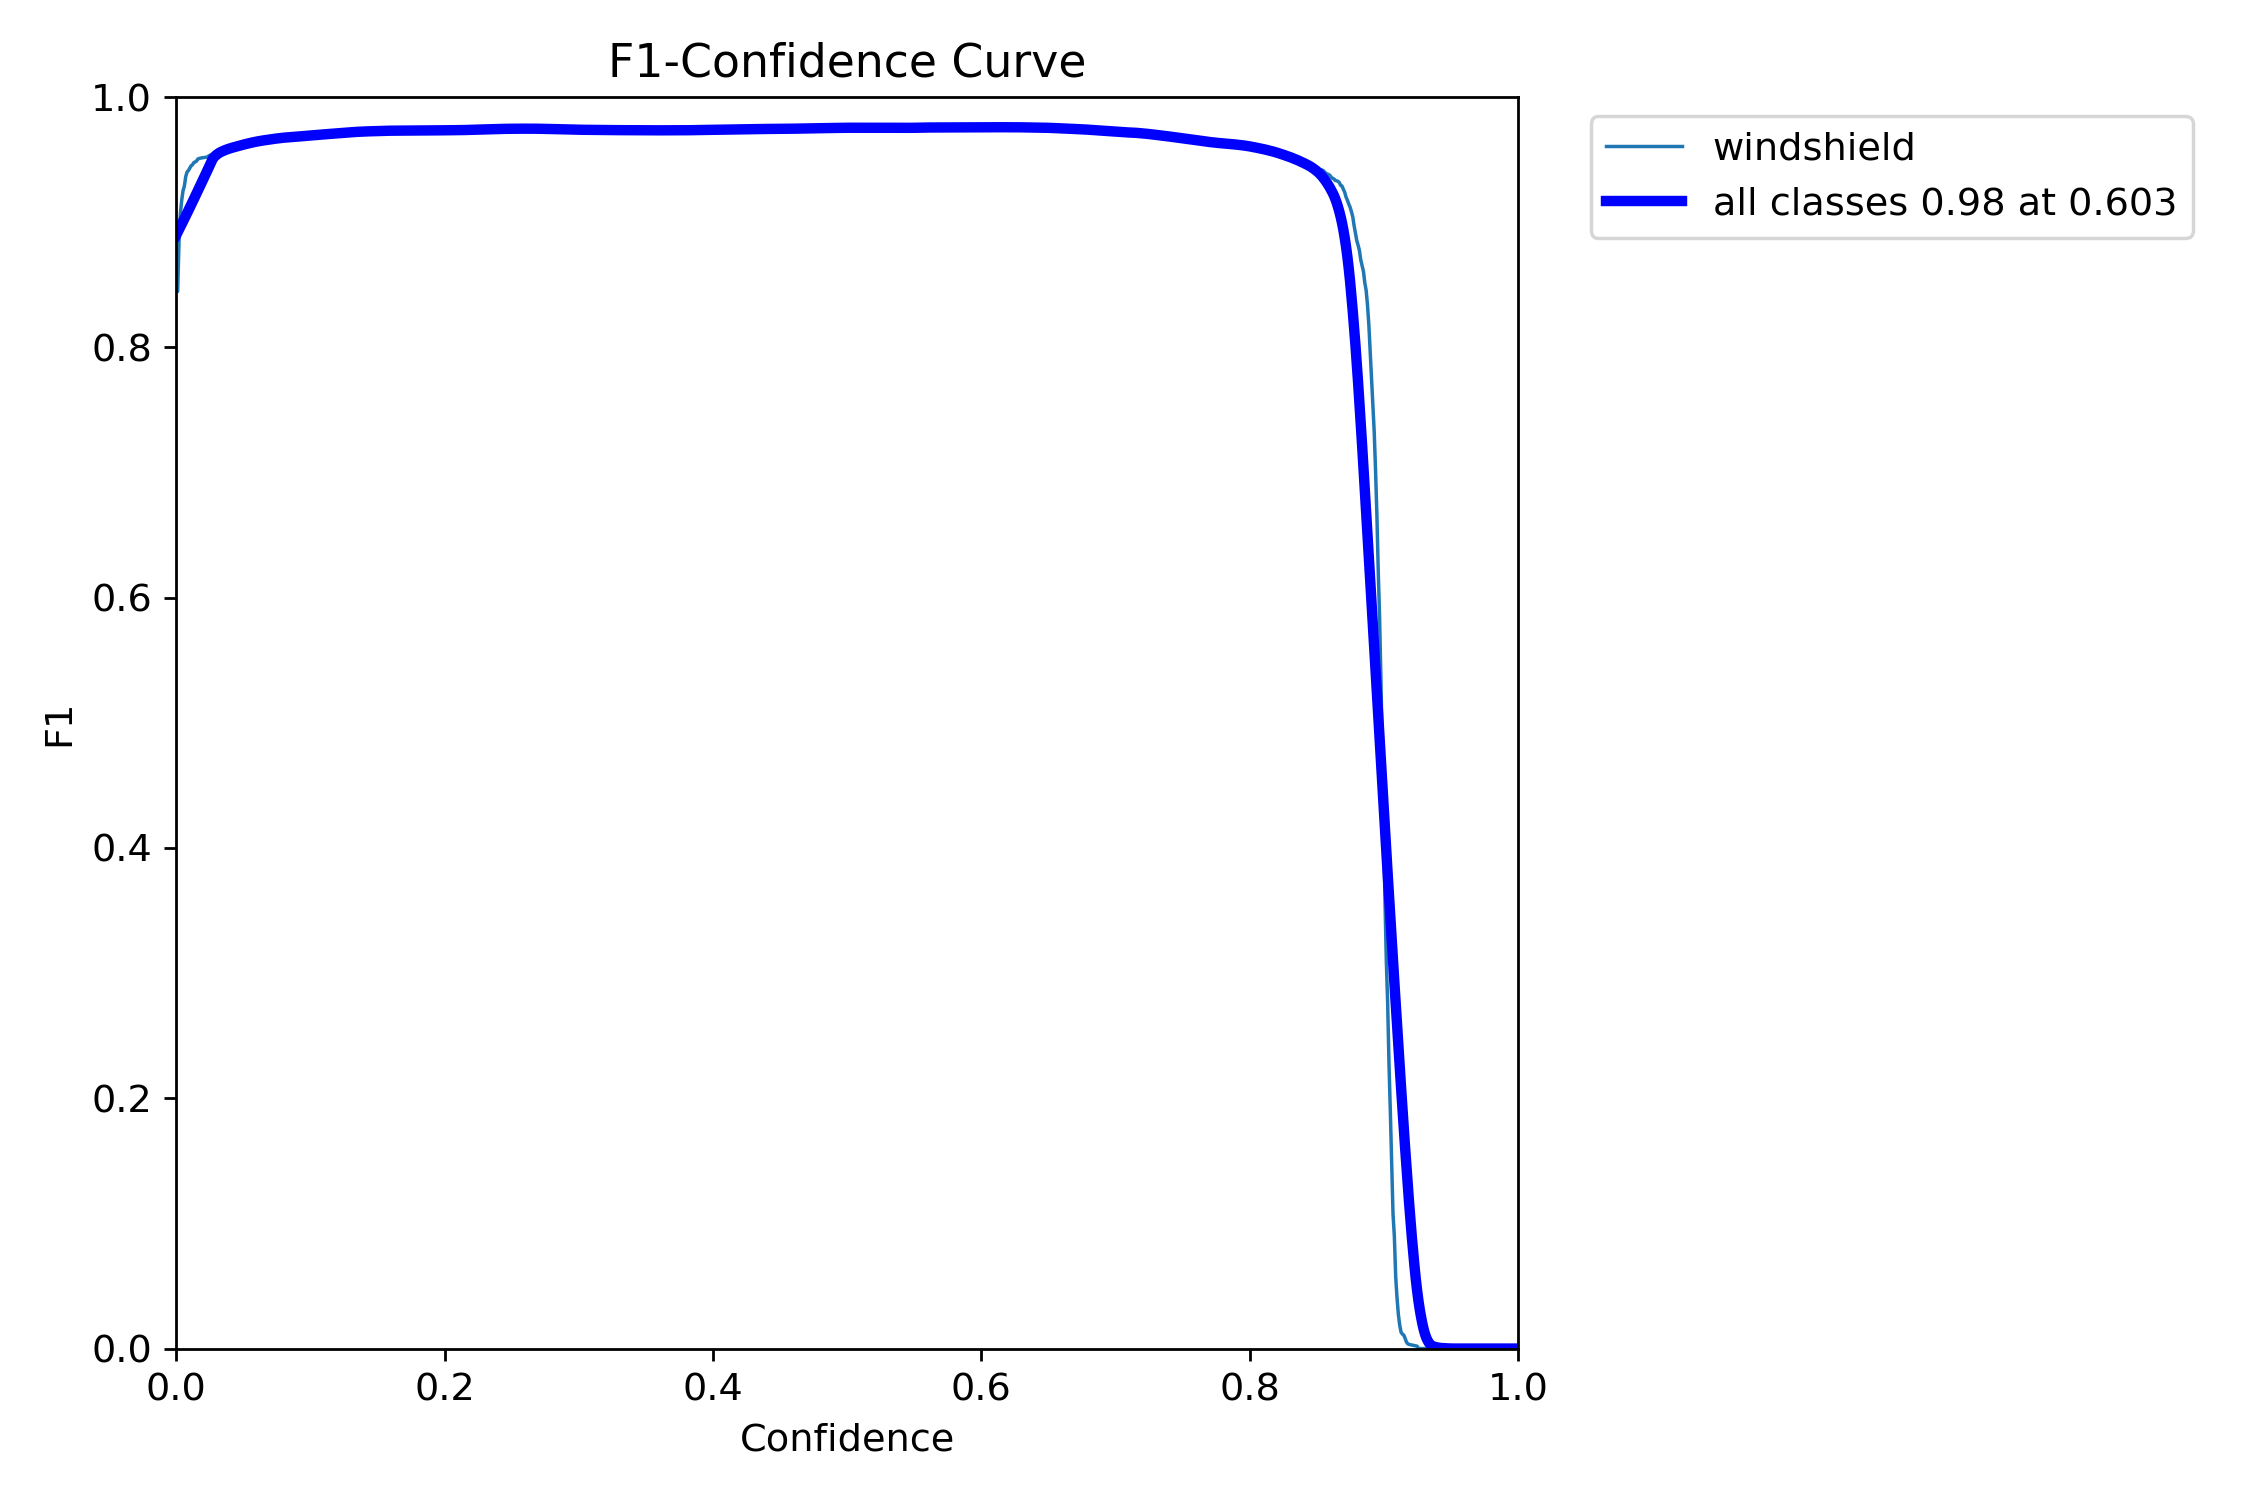

In [4]:
display(Image(filename="runs/detect/val/F1_curve.png"))

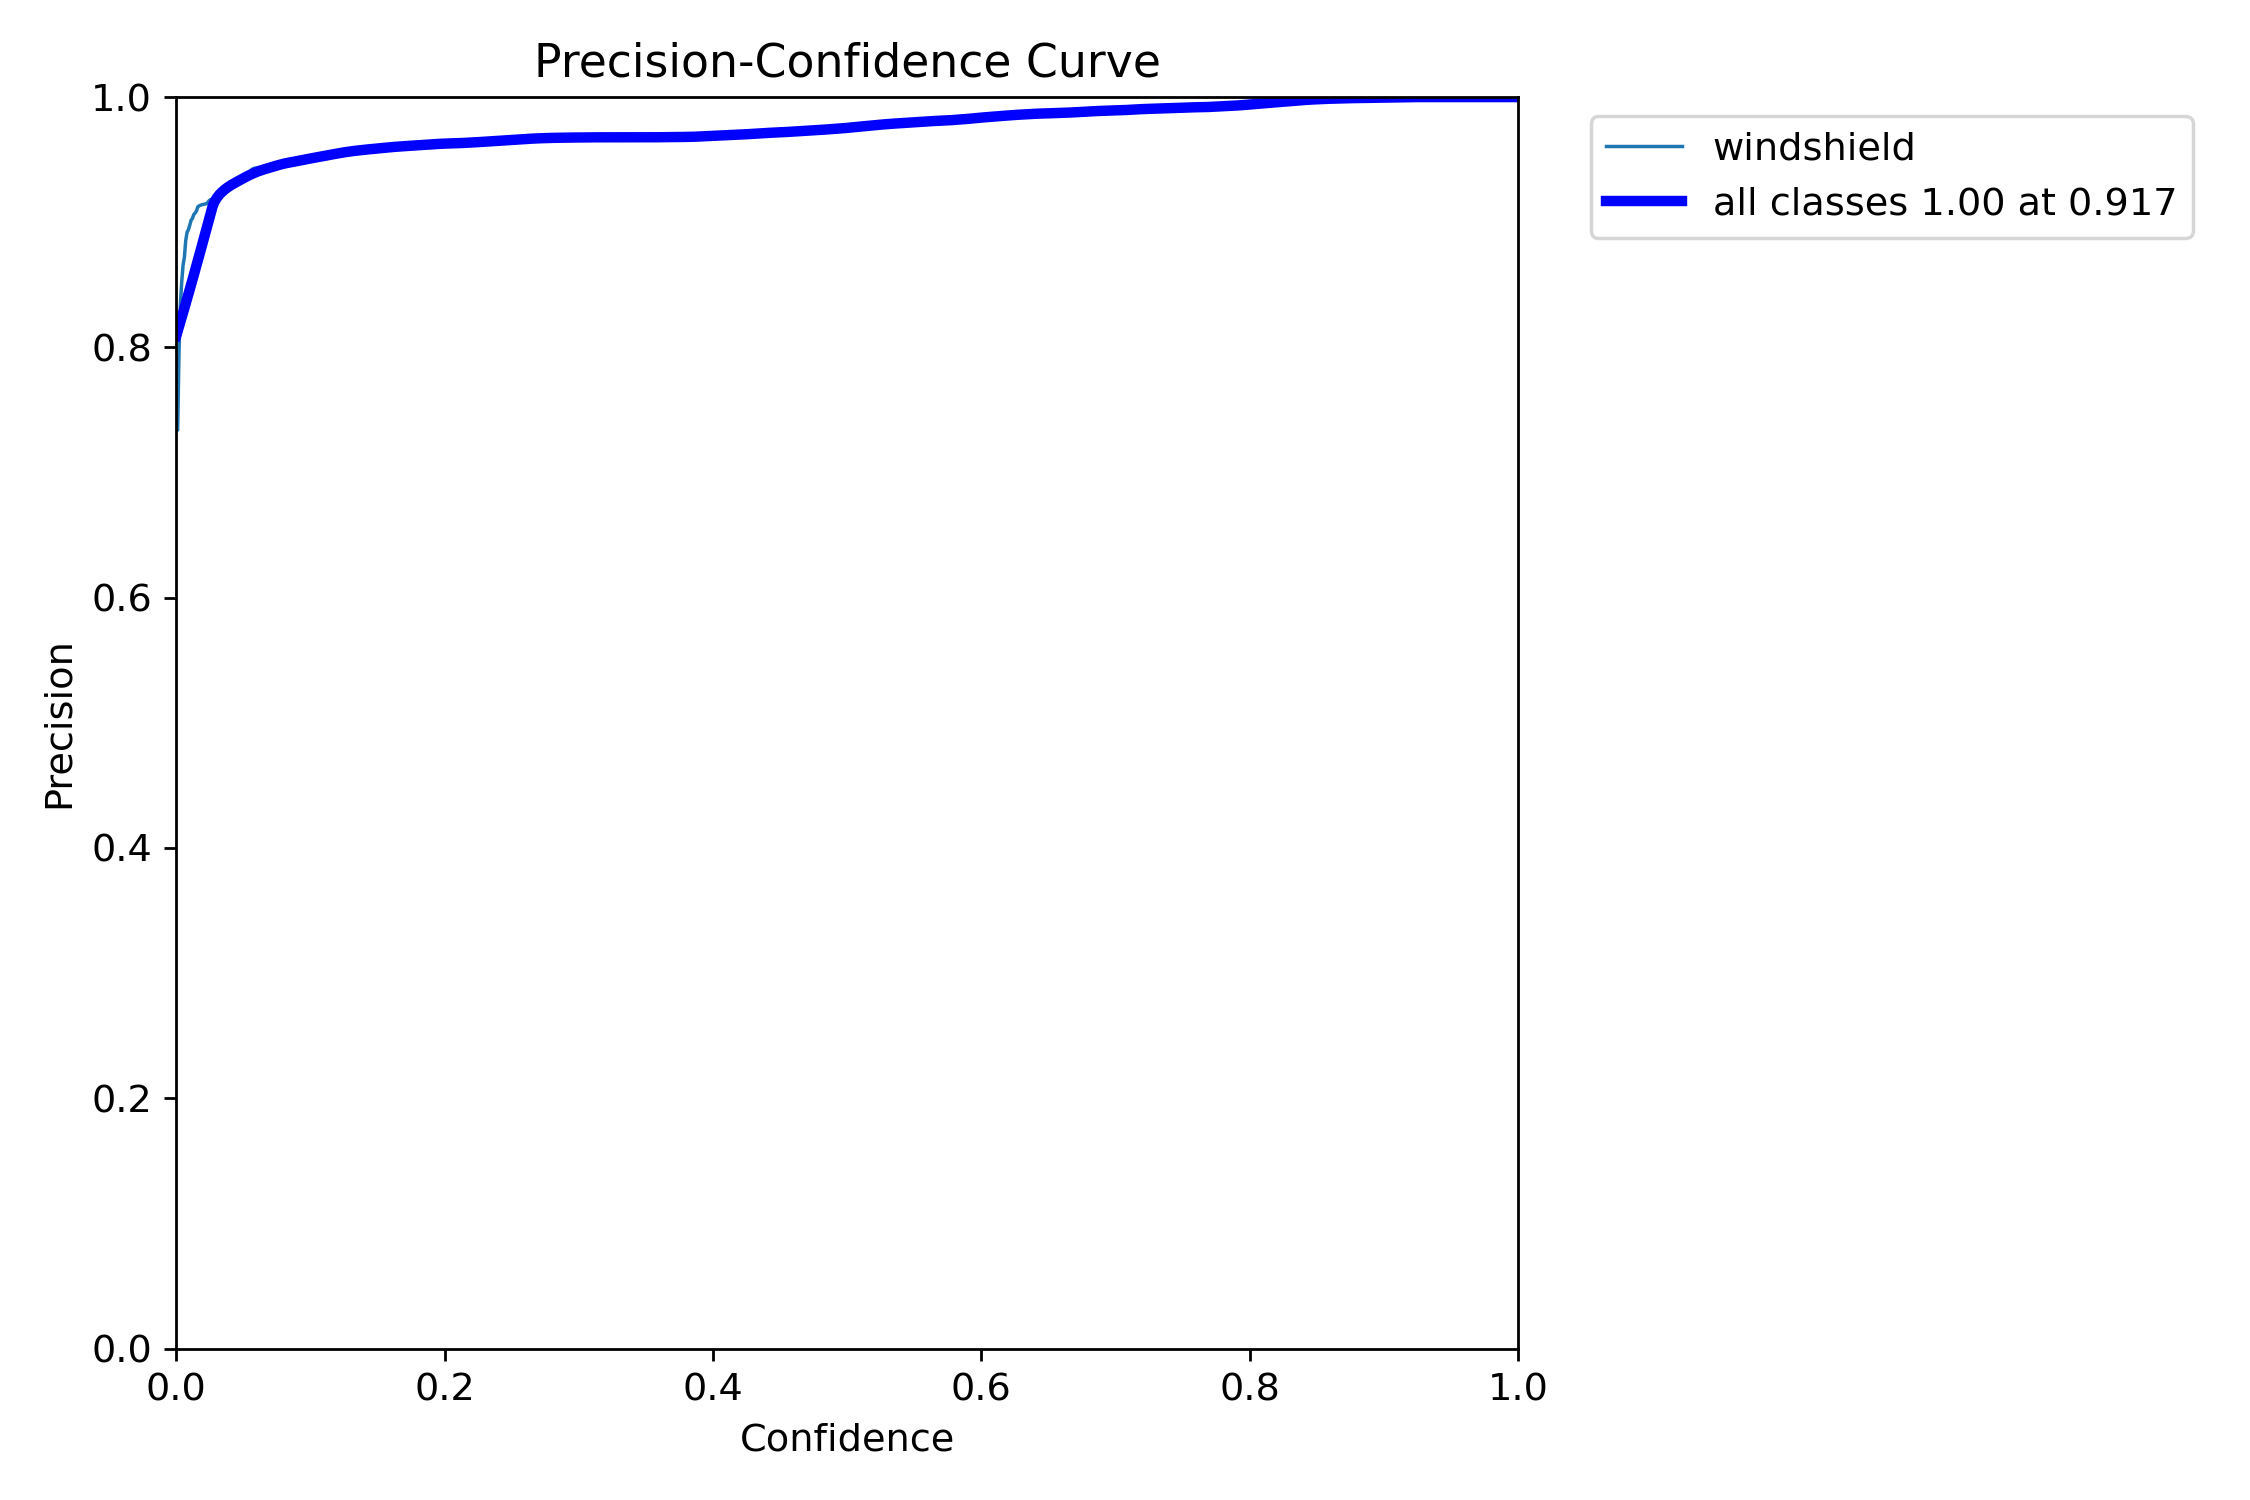

In [17]:
display(Image(filename="runs/detect/val/P_curve.png"))

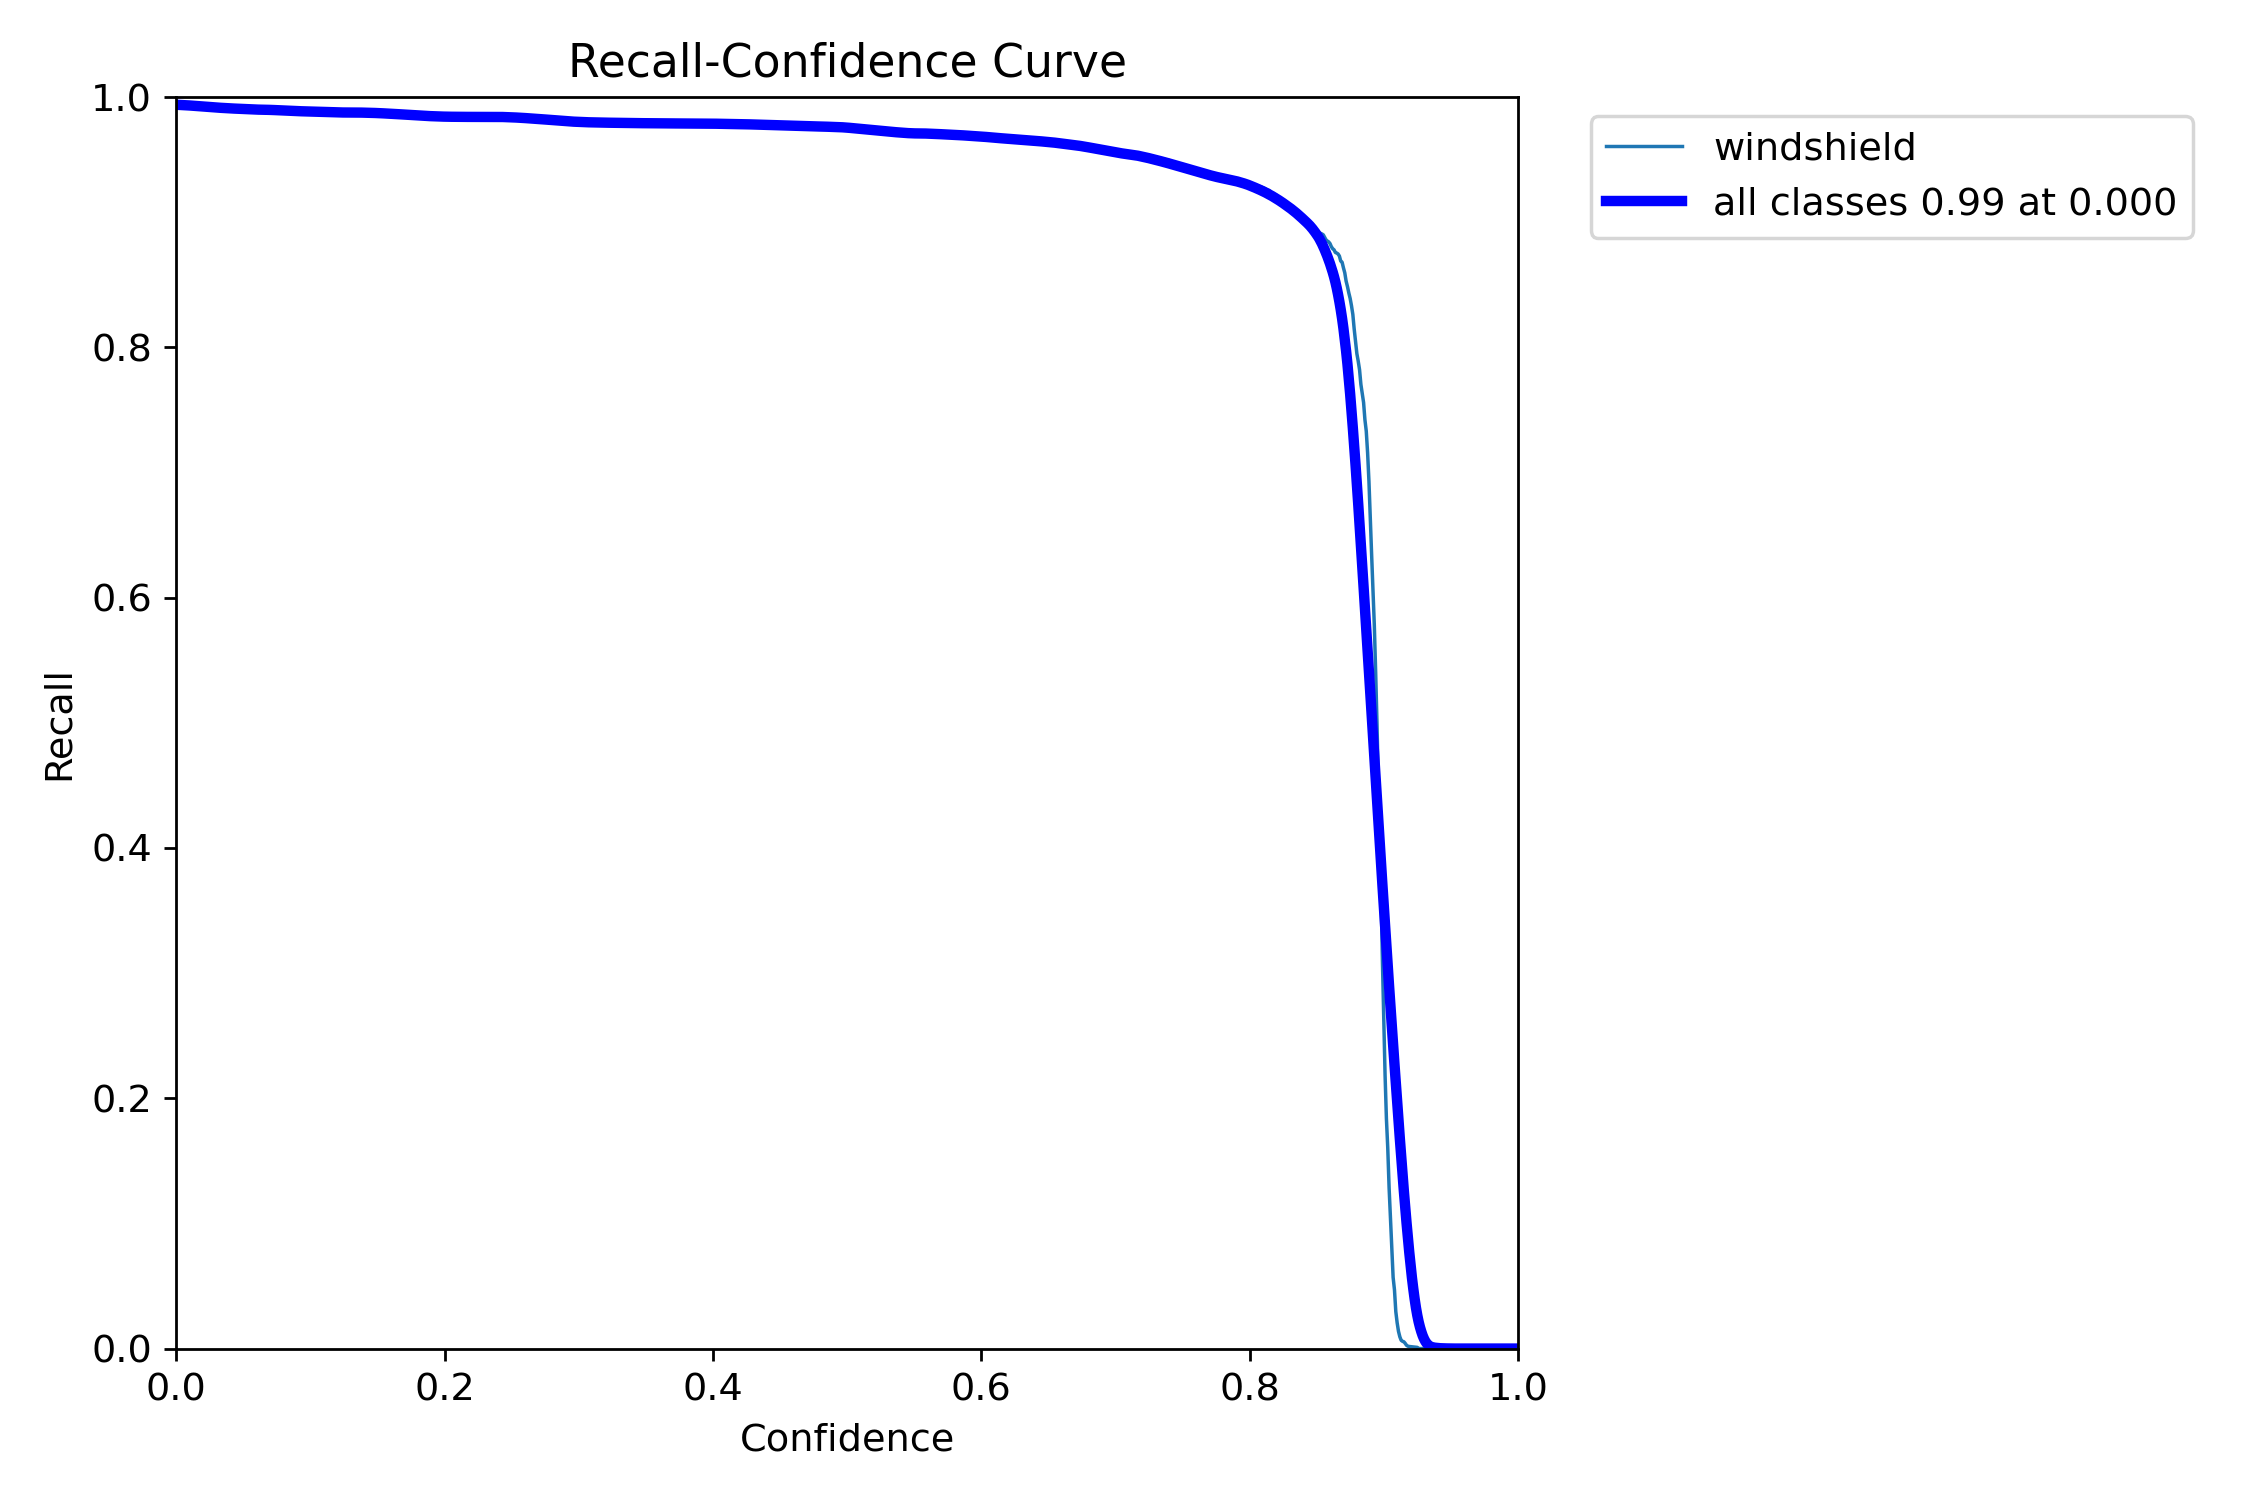

In [18]:
display(Image(filename="runs/detect/val/R_curve.png"))

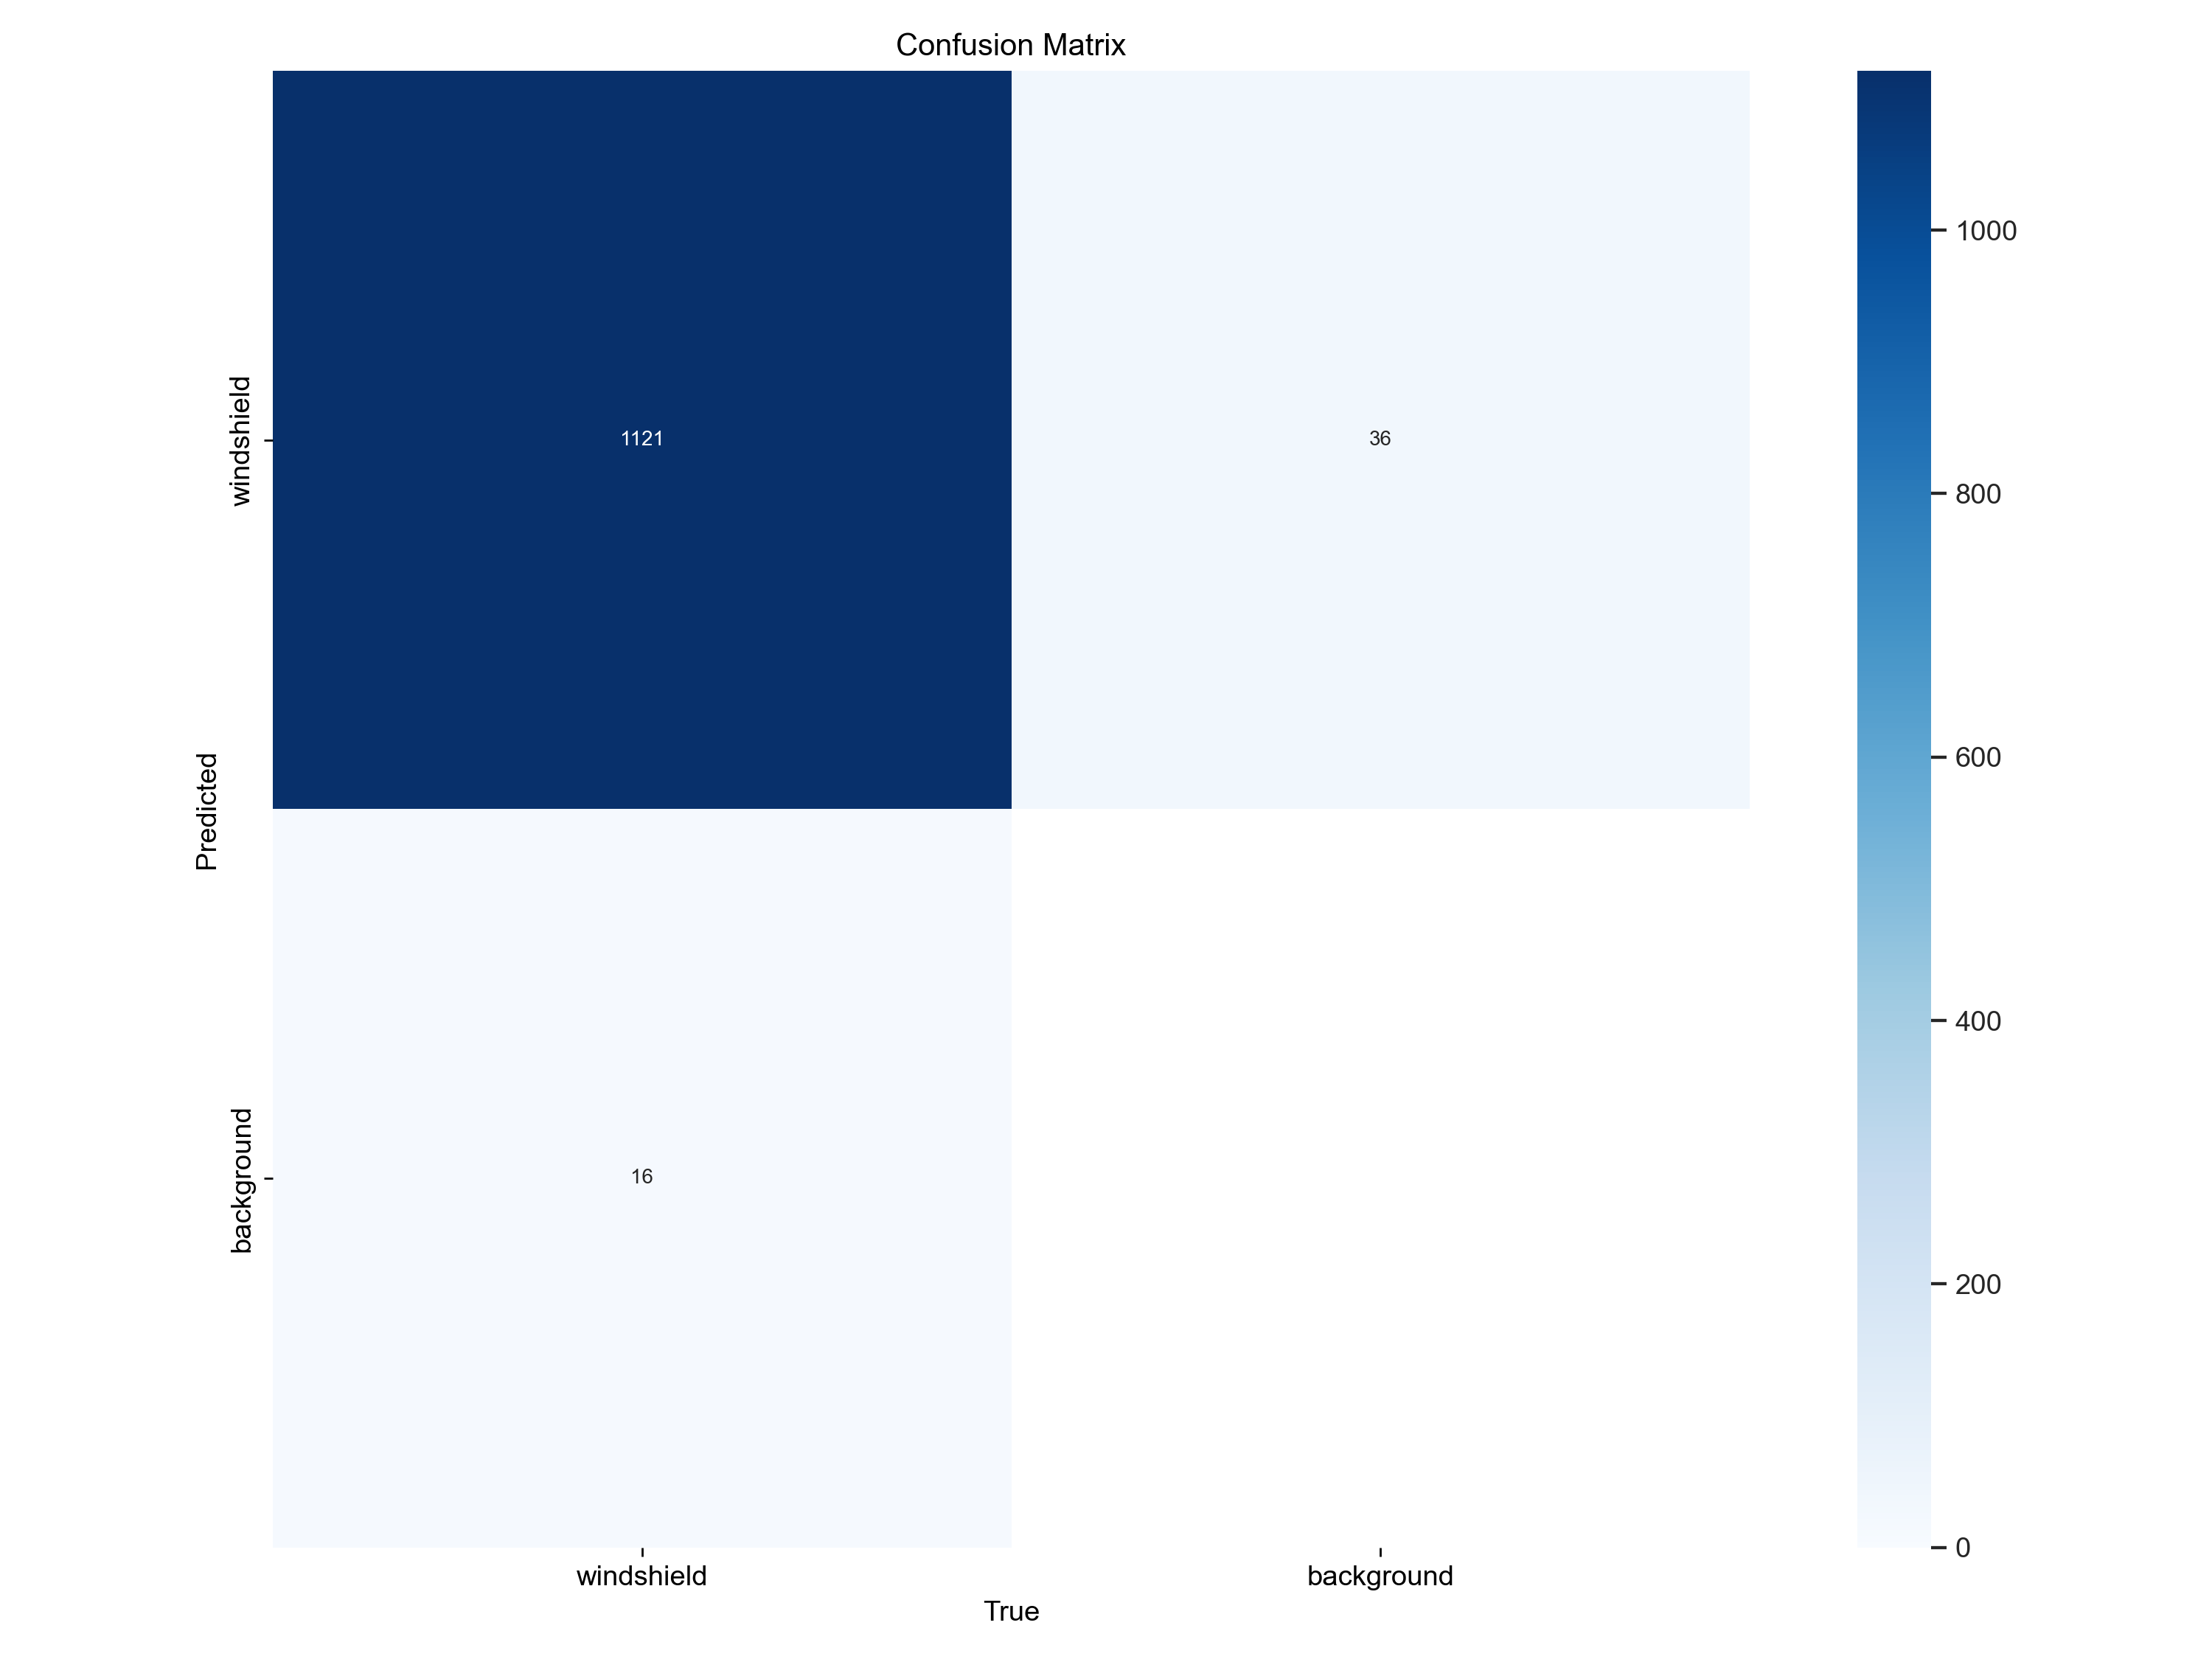

In [19]:
display(Image(filename="runs/detect/val/confusion_matrix.png"))

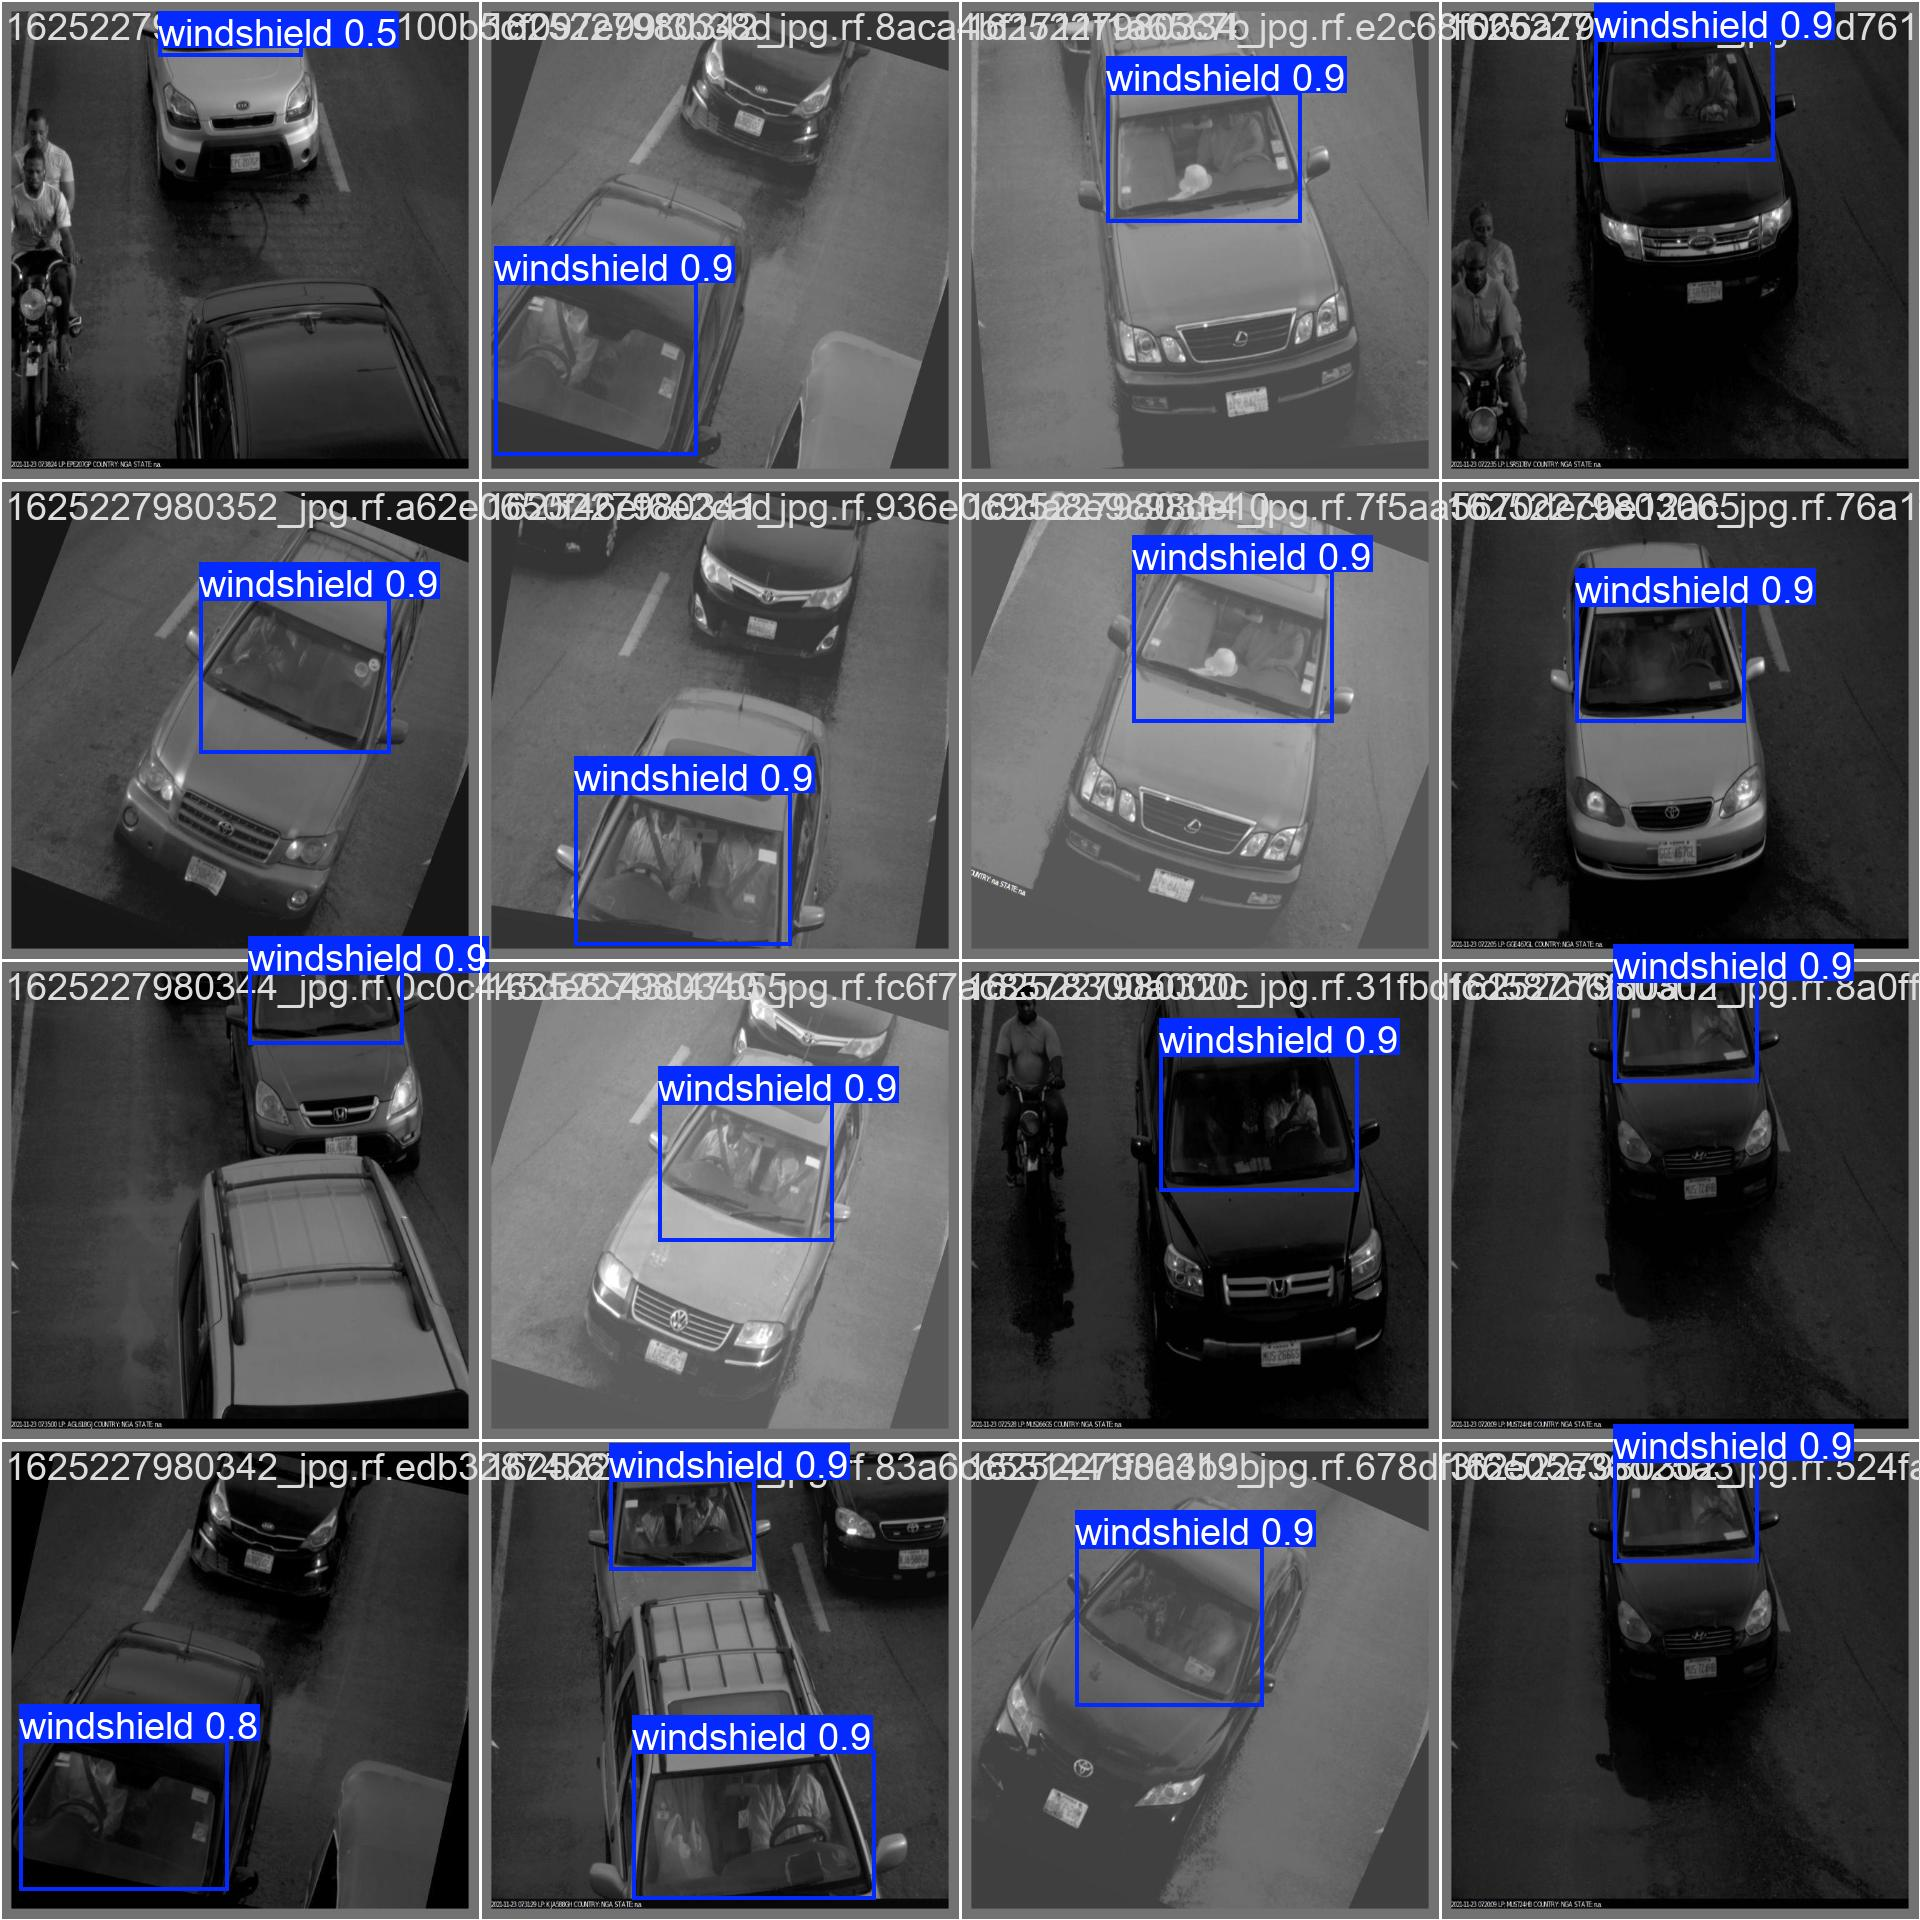

In [16]:
display(Image(filename="runs/detect/val/val_batch2_pred.jpg"))

In [5]:
results_test= model.val(data="data.yaml", task="detect",device=device, split="test")

Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning C:\Users\Tamer\OneDrive\Documents\GitHub\Seat_Belt_Detection\test\labels.cache... 366 images, 0 backgrounds, 0 corrupt: 100%|██████████| 366/366 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 2, len(boxes) = 428. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.59it/s]


                   all        366        428       0.98      0.984      0.994      0.793
Speed: 0.4ms preprocess, 9.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to C:\Users\Tamer\runs\detect\val12


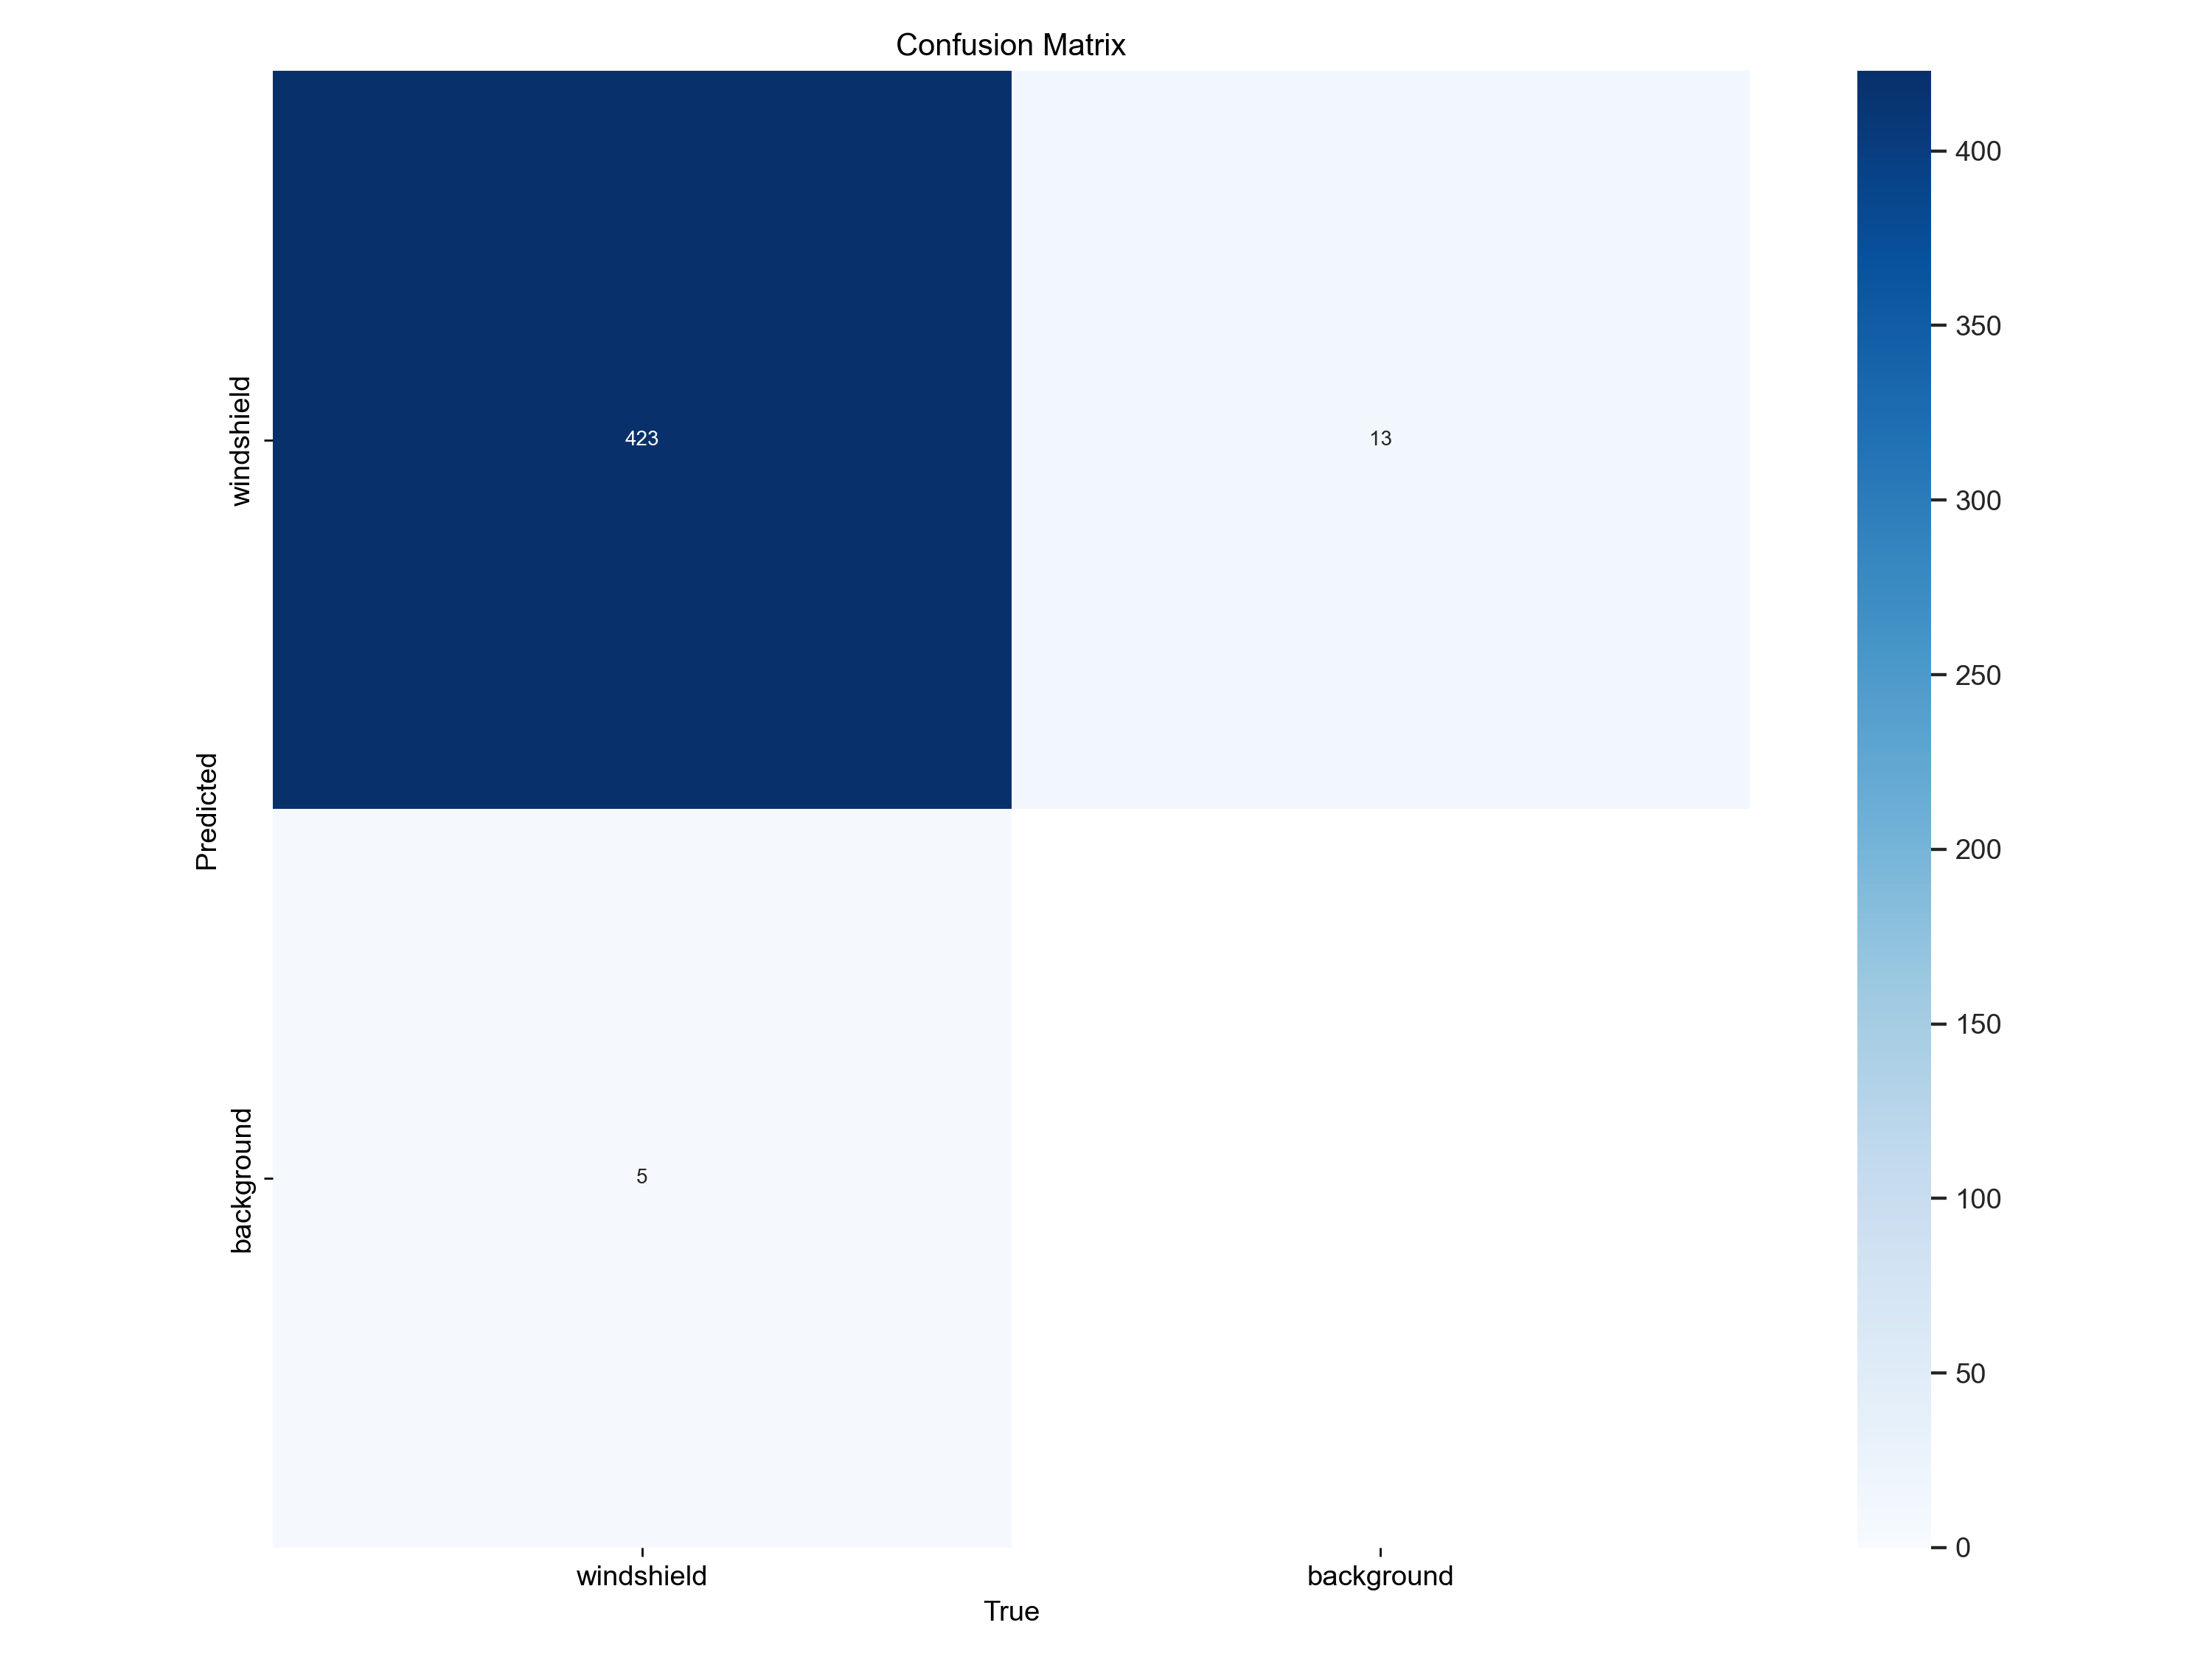

In [20]:
display(Image(filename="runs/detect/test/confusion_matrix.png"))

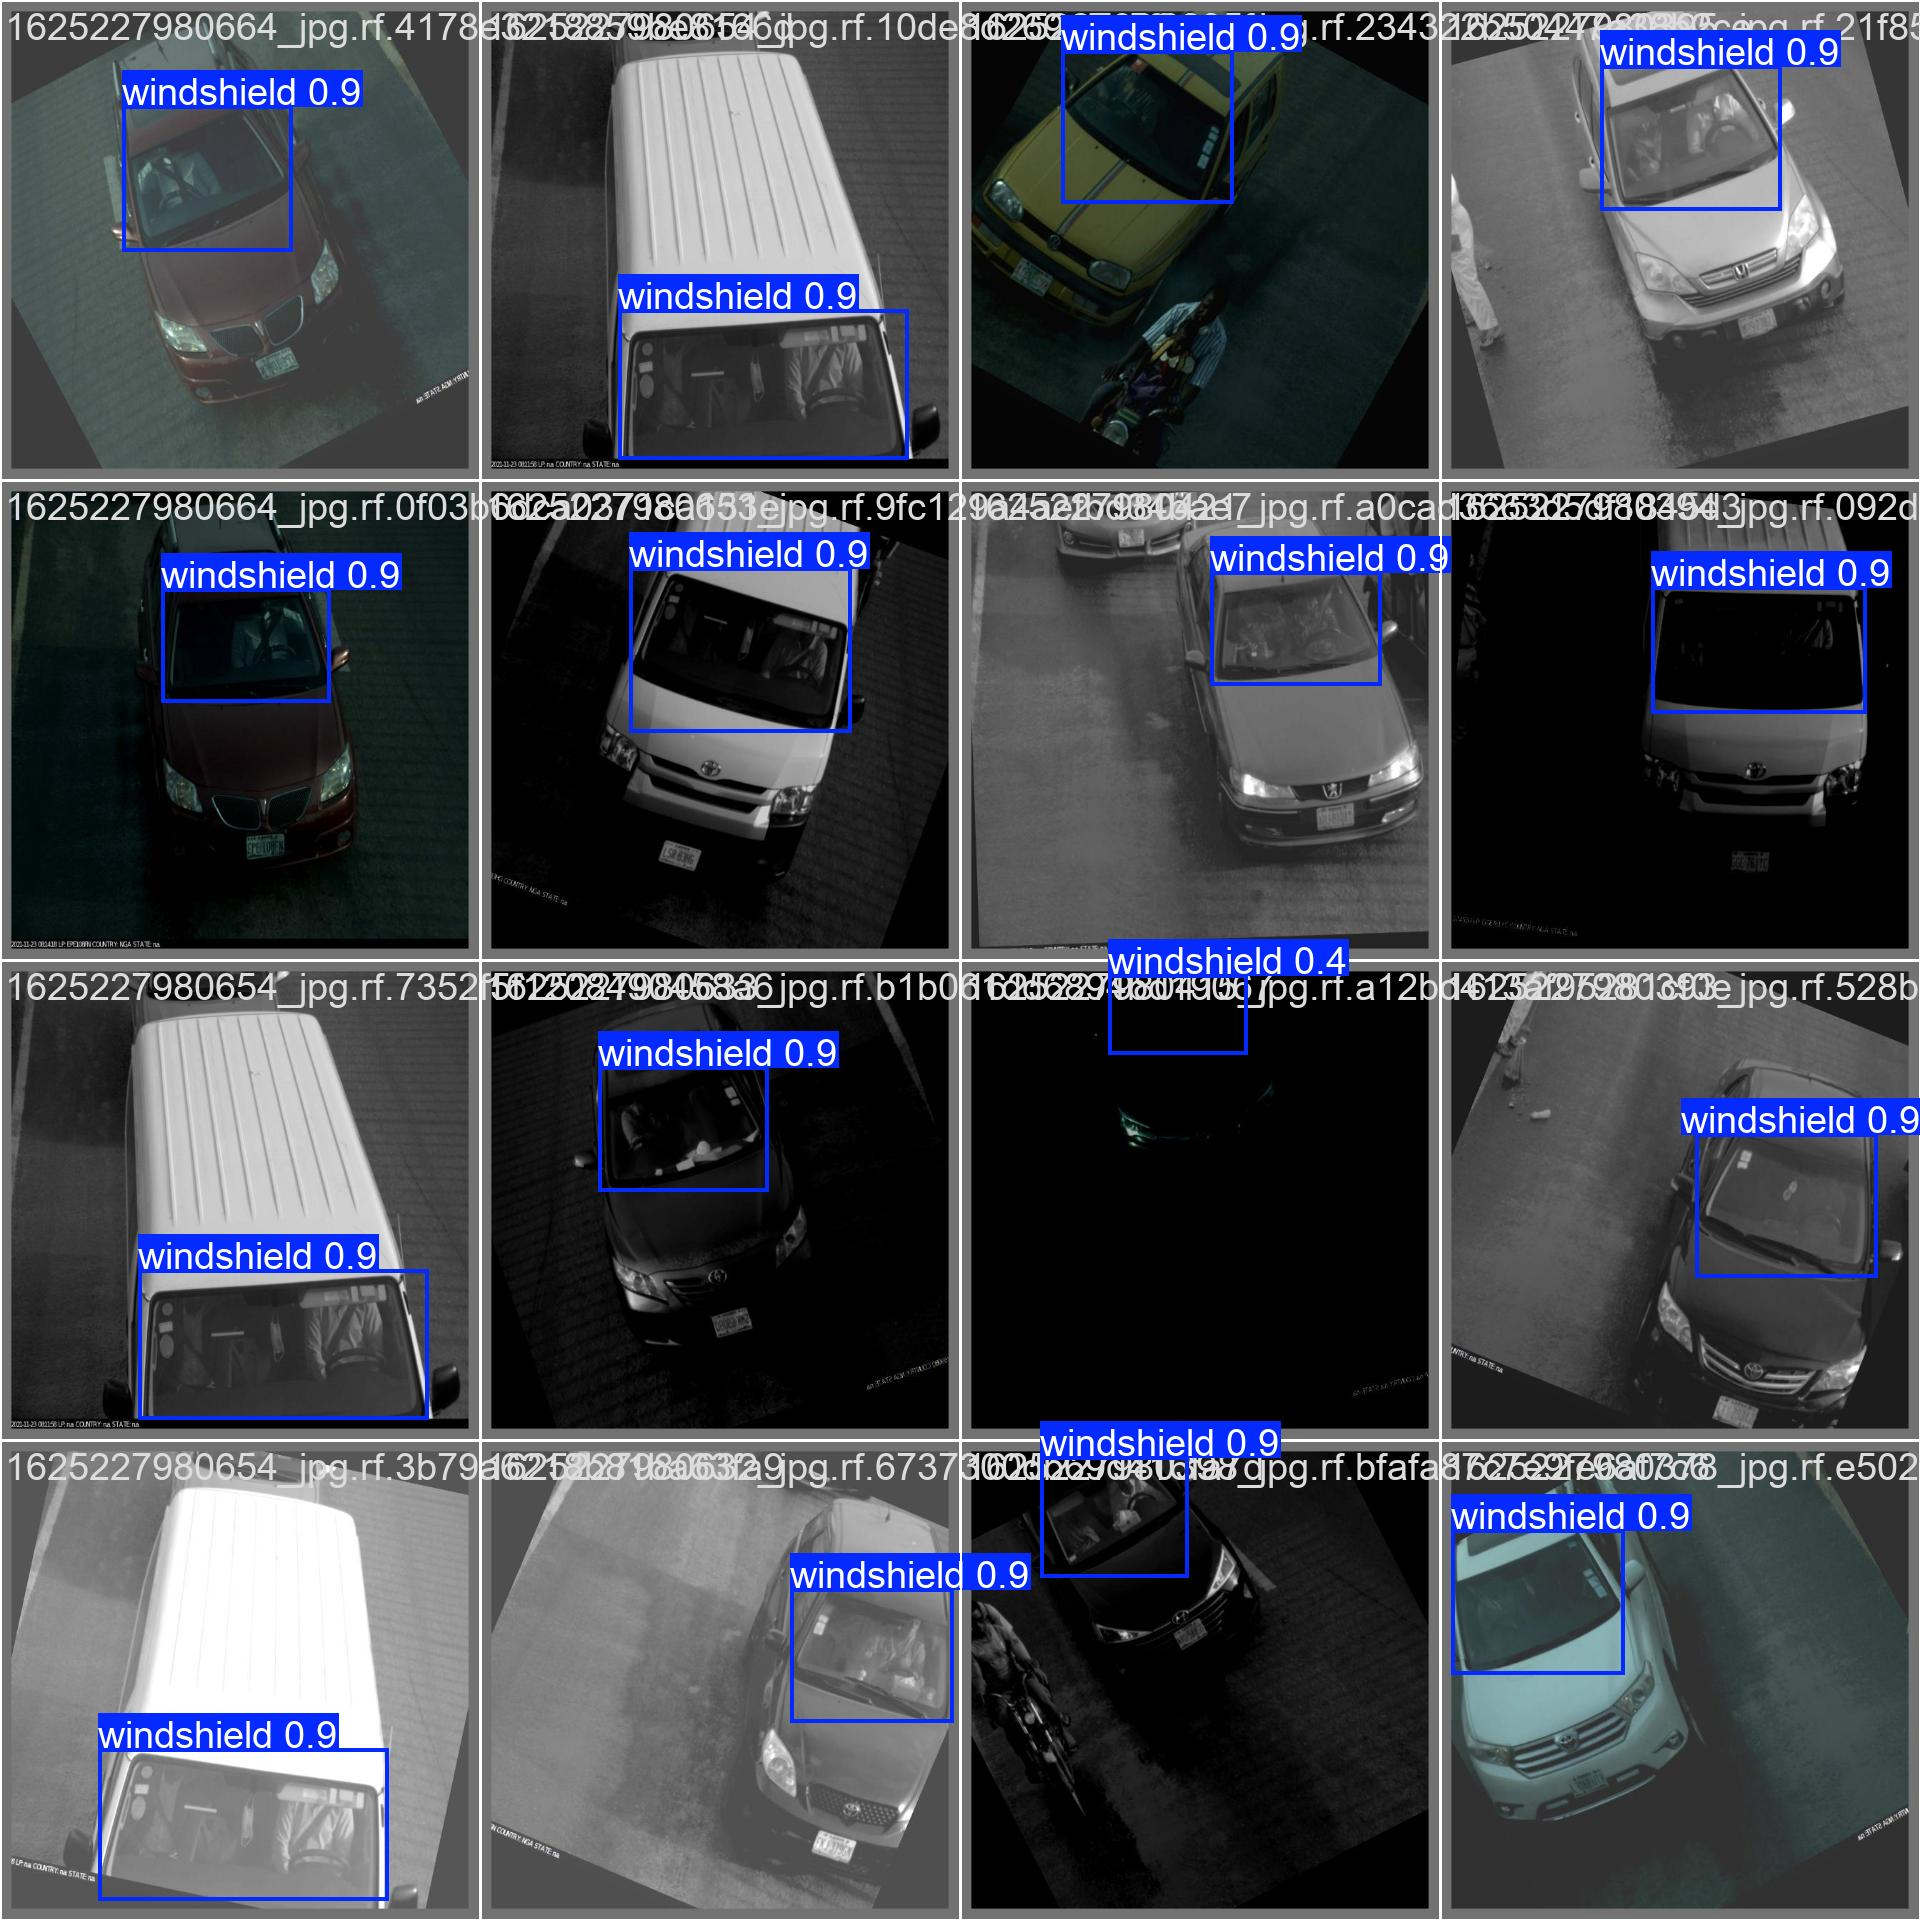

In [9]:
display(Image(filename="runs/detect/test/results.png"))